# Notebook Overview
This notebook aims to analyze the relationship between different centrality measures and various ground truths related to case importance. The goal is to identify the best combinations of centrality measures that can be used to predict case importance more accurately. 

## Notebook Structure:
1. **Data Preparation:** 
    - Preprocess the dataset to ensure it includes all relevant columns and filters out uncomputed metric values.
    - Invert the ground truth scales for intuitive correlation interpretation.

2. **Correlation Calculation:** 
    - Calculate and plot correlations between individual centrality measures and the inverted ground truths.
    - Identify complementary centralities that perform well for different types of cases.

3. **Joint Centrality Creation:**
    - Combine centralities to create joint centrality measures that better predict case importance.
    - Correlate and plot these joint centralities against all inverted ground truths.

4. **Visualization and Analysis:**
    - Visualize the effectiveness of each joint centrality measure across multiple ground truths.
    - Interpret the results to understand the strengths and weaknesses of different centrality combinations.

This notebook will help in deriving insights into how different centralities and their combinations relate to the importance of cases, facilitating a more nuanced approach to predicting case outcomes.

## Task List:

- Add more centrality meausures (i.e. disruption)
- Run correlation between the 3 ground truths
- Run correlations between centrality measures and the different ground truths (3: importance, branch, annotator score, ) -> baseline
- Create plots
    - y axis: importance
    - x axis: centrality score
- Inspect the plots
- Filter out
    - Based on the highest score (1) 
    - Look for centralities scores that have low error bars for the highest categories
    - (Data is skewed, correlation might relate to the class with the most observations)
    - Find a centrality measure with low error bars in a high centrality score -> find cutout range
    - Find a centrality that does the opposite (low error bars in low centrality score) ->  find cutout range
    - Define rule to split between 
        - Hard split based on the error
        - Weights depending on the gradient on how close to the error bar
- Run the correlations again


In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import dateutil.parser
import statistics
import matplotlib.pyplot as plt
# import networkit as nk

In [30]:
# CONSTANTS
# Simplified CSV
SIMPLIFIED_CSV = '../data/raw/judgments_removed_degree_15orless_in_degree_5orless_TOTAL.csv'

# nodes file
NODES_FILE = '../data/raw/nodes_p1.json'
# edges file
EDGES_FILE = '../data/raw/edges_p1.json'

# Centralities of interest
CENTRALITIES = ['degree_centrality', 'in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 'core_number', 
                'relative_in_degree_centrality', 'eigenvector_centrality', 
                'pagerank', 'hits_hub', 'hits_authority', 'harmonic_centrality', 'disruption']

# Ground truths of interest
GROUND_TRUTHS = ['importance', 'scaled_average_score', 'doctypebranch']
GROUND_TRUTHS_INVERTED = ['importance_inverted', 'scaled_average_score_inverted', 'doctypebranch_inverted']


In [31]:

# Load the simplified CSV file
file_path = '../data/raw/judgments_removed_degree_15orless_in_degree_5orless_TOTAL.csv'
judgments_df = pd.read_csv(file_path, sep=';', usecols=['A1', 'A2', 'A3', 'court branch', 'ECLI'])

# Ensure each row has the same number of columns
judgments_df.dropna(how='any', inplace=True)

# Convert A1, A2, and A3 to numeric values, coercing errors to NaN and then dropping rows with NaN values
judgments_df[['A1', 'A2', 'A3']] = judgments_df[['A1', 'A2', 'A3']].apply(pd.to_numeric, errors='coerce')
judgments_df.dropna(subset=['A1', 'A2', 'A3'], inplace=True)

# Drop branch column
judgments_df.drop(columns=['court branch'], inplace=True)

# Calculate the total score as the sum of scores from A1, A2, and A3
judgments_df['total_score'] = judgments_df[['A1', 'A2', 'A3']].sum(axis=1)

# Calculate the average score of the three annotators
judgments_df['average_score'] = judgments_df[['A1', 'A2', 'A3']].astype(float).mean(axis=1)

# Load nodes and edges JSON files
nodes_file_path = '../data/raw/nodes_p1.json'
edges_file_path = '../data/raw/edges_p1.json'

nodes_df = pd.read_json(nodes_file_path)
edges_df = pd.read_json(edges_file_path)

# Merge judgments_df with nodes_df to get "importance" and "doctypebranch"
merged_df = pd.merge(judgments_df, nodes_df[['ecli', 'importance', 'doctypebranch']], left_on='ECLI', right_on='ecli', how='left')
print("After merge, columns:", merged_df.columns)
print(merged_df[['ECLI', 'importance', 'doctypebranch']].head())

# High importance (1) should correspond to a high scaled score (e.g., 3 for average score and 9 for total score)
# Lower importance (3 or 4) should correspond to lower scaled scores.

max_average_score = 2

# Invert the scores: Higher original scores will become lower, to match the reverse importance scale
merged_df['inverted_average_score'] = merged_df['average_score'].max() - merged_df['average_score']

# Scale the inverted scores to the desired range
merged_df['scaled_average_score'] = (merged_df['inverted_average_score'] / merged_df['inverted_average_score'].max()) * max_average_score

# Round the scores to a whole number scale of 0, 1, or 2
merged_df['scaled_average_score'] = merged_df['scaled_average_score'].round()

# Drop the intermediate inverted columns if not needed
merged_df.drop(columns=['inverted_average_score'], inplace=True)

# Convert doctypebranch to a numeric value
def categorise_branch_numerically(branches: pd.Series) -> pd.Series:
    """
    Convert branch categorisation from strings into numbers.
    
    :param branches: The column containing branch data, categorized with strings.
    :return: A pandas Series with numerical categorization.
    """
    mapping = {
        "GRANDCHAMBER": 1,
        "CHAMBER": 2,
        "COMMITTEE": 3
    }
    return branches.map(mapping).fillna(0)  # Filling NaN with 0 or another default value if needed
merged_df['doctypebranch'] = categorise_branch_numerically(merged_df['doctypebranch'])

# Print an overview of the merged DataFrame
print(merged_df.info())
print(merged_df.head())
print(merged_df.describe())

# Create a graph from the edges data
G = nx.DiGraph()

# Add nodes with attributes from the merged DataFrame
for idx, row in merged_df.iterrows():
    G.add_node(row['ECLI'], average_score=row['scaled_average_score'], 
               importance=row['importance'], doctypebranch=row['doctypebranch'])

# Add edges from the edges DataFrame
for idx, row in edges_df.iterrows():
    source = row['ecli']
    targets = row['references']
    for target in targets:
        if target:  # Ensure the target is not null
            G.add_edge(source, target)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))



After merge, columns: Index(['A1', 'A2', 'A3', 'ECLI', 'total_score', 'average_score', 'ecli',
       'importance', 'doctypebranch'],
      dtype='object')
                                 ECLI  importance doctypebranch
0  ECLI:CE:ECHR:1979:0613JUD000683374           2       CHAMBER
1  ECLI:CE:ECHR:1982:0225JUD000751176           2       CHAMBER
2  ECLI:CE:ECHR:1982:0923JUD000715175           2       CHAMBER
3  ECLI:CE:ECHR:1983:1123JUD000891980           2       CHAMBER
4  ECLI:CE:ECHR:1986:0221JUD000879379           2       CHAMBER
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   A1                    243 non-null    int64  
 1   A2                    243 non-null    int64  
 2   A3                    243 non-null    int64  
 3   ECLI                  243 non-null    object 
 4   total_score           243 non-null    int64 

# Calculate Centralities

In [32]:
def calculate_disruptions_new(graph: nx.Graph) -> dict:
    """
    Calculate the disruption score for each node in the graph.

    Args:
        graph (nx.Graph): The input directed graph.

    Returns:
        dict: A dictionary with nodes as keys and their disruption scores as values.
    """
    disruptions = {}
    for node in graph.nodes:
        i, j, k = 0, 0, 0

        # count j
        for in_node in graph.predecessors(node):
            for out_node in graph.successors(node):
                if graph.has_edge(in_node, out_node):
                    j += 1
                    break

        # count i
        i = graph.in_degree(node) - j

        # count k
        for out_node in graph.successors(node):
            for in_out_node in graph.predecessors(out_node):
                if in_out_node != node and not graph.has_edge(in_out_node, node):
                    k += 1

        try:
            disruptions[node] = (i - j) / (i + j + k)
        except ZeroDivisionError:
            disruptions[node] = np.nan

    return disruptions


# Function to calculate centrality measures
def calculate_centrality_measures(graph):
    degree_centrality = nx.degree_centrality(graph)
    in_degree_centrality = nx.in_degree_centrality(graph)
    out_degree_centrality = nx.out_degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph, normalized=True)
    closeness_centrality = nx.closeness_centrality(graph)
    
    # Additional centrality measures
    core_number = nx.core_number(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    pagerank = nx.pagerank(graph)
    # current_flow_betweenness_centrality = nx.current_flow_betweenness_centrality(graph)
    harmonic_centrality = nx.harmonic_centrality(graph)
    
    # For HITS, we get both hub and authority scores
    hits_hub, hits_authority = nx.hits(graph)
    
    # Trophic level calculation
    # Note: NetworkX doesn't have a built-in function for trophic level, so this is a placeholder
    # trophic_level = {node: 0 for node in graph.nodes}  # Placeholder implementation
    
    # Relative in-degree centrality
    total_nodes = len(graph.nodes)
    relative_in_degree_centrality = {node: in_degree / total_nodes for node, in_degree in in_degree_centrality.items()}
    
    # Placeholder for Forest Closeness and Disruption as these are not standard in NetworkX
    # forest_closeness = {node: 0 for node in graph.nodes}  # Placeholder implementation
    disruption = calculate_disruptions_new(graph)  # Placeholder implementation

    return {
        'degree_centrality': degree_centrality,
        'in_degree_centrality': in_degree_centrality,
        'out_degree_centrality': out_degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality,
        'core_number': core_number,
        'relative_in_degree_centrality': relative_in_degree_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'pagerank': pagerank,
        # 'current_flow_betweenness_centrality': current_flow_betweenness_centrality,
        'hits_hub': hits_hub,
        'hits_authority': hits_authority,
        'harmonic_centrality': harmonic_centrality,
        'disruption': disruption,
    }


# TODO: Check if turning the graph into an indirected graph is a vialable option

# Calculate centrality measures
centrality_measures = calculate_centrality_measures(G)

# Convert centrality measures to DataFrame for easier manipulation
centrality_df = pd.DataFrame(centrality_measures)

# Merge centrality measures with judgments data
merged_df = merged_df.merge(centrality_df, left_on='ECLI', right_index=True, how='left')

# Display an overview of the merged DataFrame
print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   A1                             243 non-null    int64  
 1   A2                             243 non-null    int64  
 2   A3                             243 non-null    int64  
 3   ECLI                           243 non-null    object 
 4   total_score                    243 non-null    int64  
 5   average_score                  243 non-null    float64
 6   ecli                           243 non-null    object 
 7   importance                     243 non-null    int64  
 8   doctypebranch                  243 non-null    int64  
 9   scaled_average_score           243 non-null    float64
 10  degree_centrality              243 non-null    float64
 11  in_degree_centrality           243 non-null    float64
 12  out_degree_centrality          243 non-null    flo

# Calculate Correlation (centralities and average ground truth)

Columns in merged_df: Index(['A1', 'A2', 'A3', 'ECLI', 'total_score', 'average_score', 'ecli',
       'importance', 'doctypebranch', 'scaled_average_score',
       'degree_centrality', 'in_degree_centrality', 'out_degree_centrality',
       'betweenness_centrality', 'closeness_centrality', 'core_number',
       'relative_in_degree_centrality', 'eigenvector_centrality', 'pagerank',
       'hits_hub', 'hits_authority', 'harmonic_centrality', 'disruption',
       'importance_inverted', 'doctypebranch_inverted',
       'scaled_average_score_inverted'],
      dtype='object')


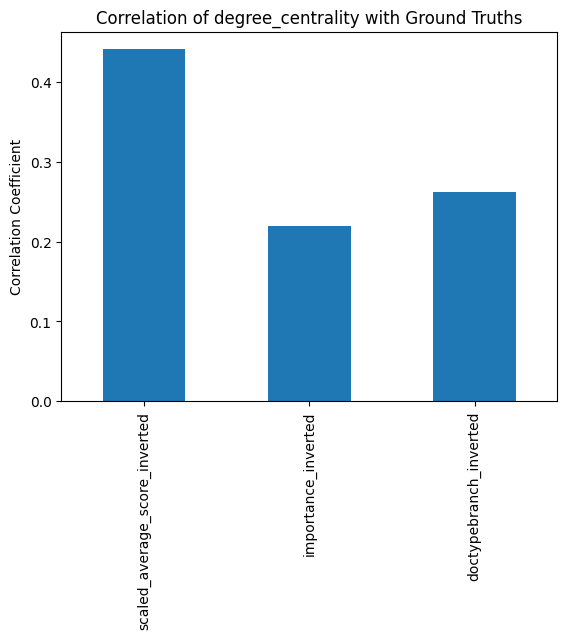

scaled_average_score_inverted    0.440753
importance_inverted              0.220041
doctypebranch_inverted           0.262587
Name: degree_centrality, dtype: float64


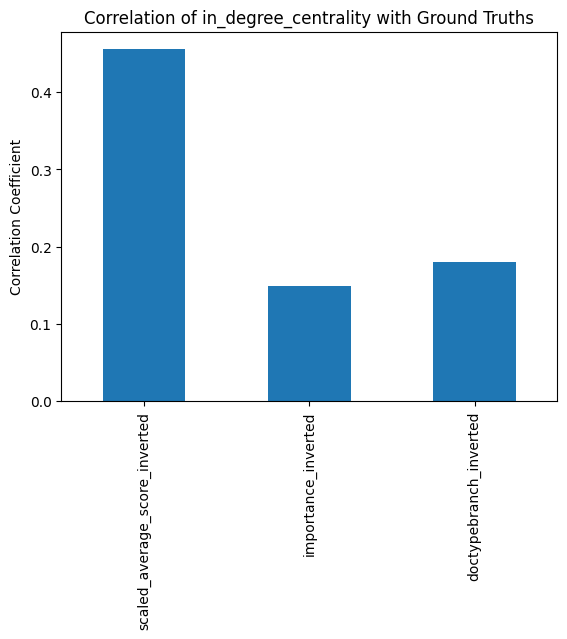

scaled_average_score_inverted    0.455383
importance_inverted              0.149238
doctypebranch_inverted           0.180201
Name: in_degree_centrality, dtype: float64


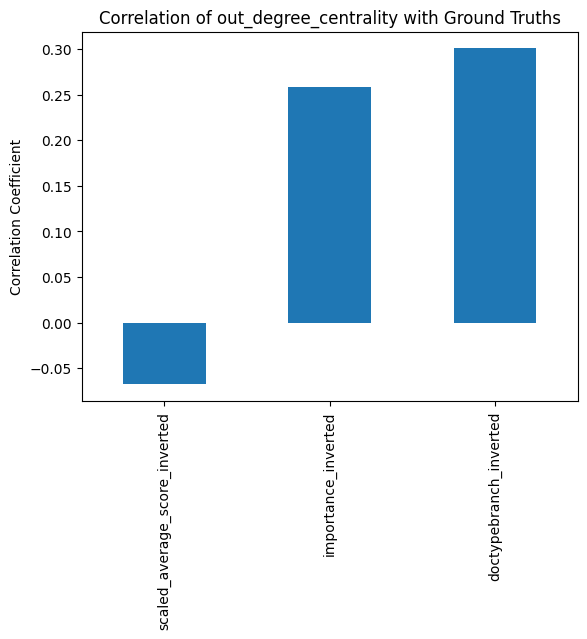

scaled_average_score_inverted   -0.067801
importance_inverted              0.258500
doctypebranch_inverted           0.300598
Name: out_degree_centrality, dtype: float64


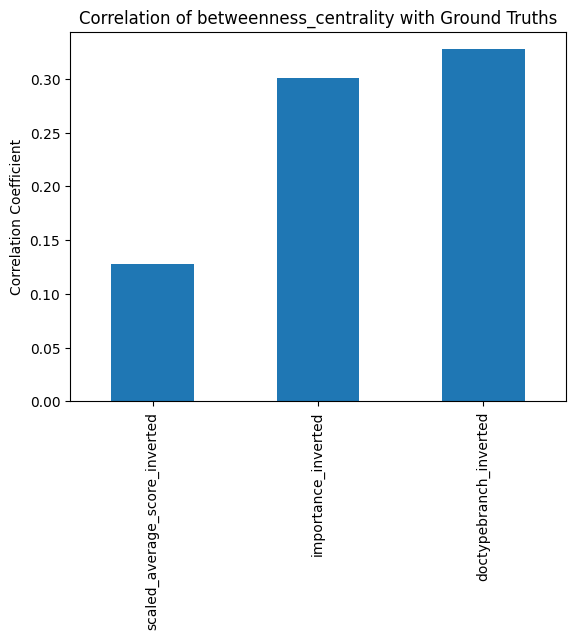

scaled_average_score_inverted    0.127886
importance_inverted              0.300891
doctypebranch_inverted           0.327437
Name: betweenness_centrality, dtype: float64


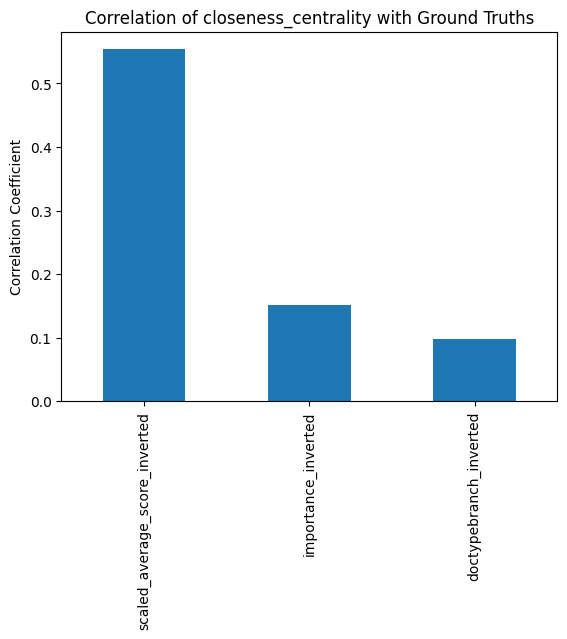

scaled_average_score_inverted    0.553658
importance_inverted              0.150886
doctypebranch_inverted           0.098352
Name: closeness_centrality, dtype: float64


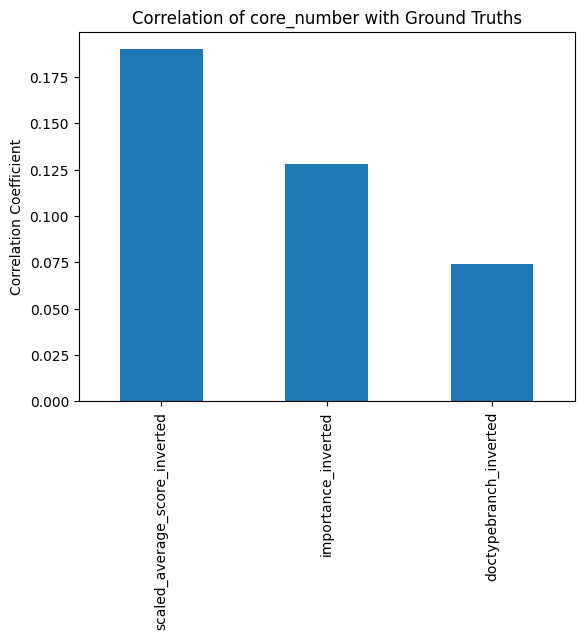

scaled_average_score_inverted    0.189936
importance_inverted              0.128227
doctypebranch_inverted           0.073907
Name: core_number, dtype: float64


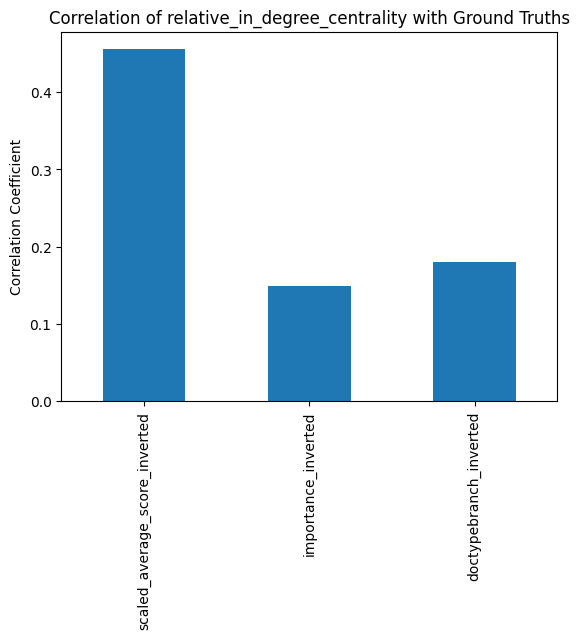

scaled_average_score_inverted    0.455383
importance_inverted              0.149238
doctypebranch_inverted           0.180201
Name: relative_in_degree_centrality, dtype: float64


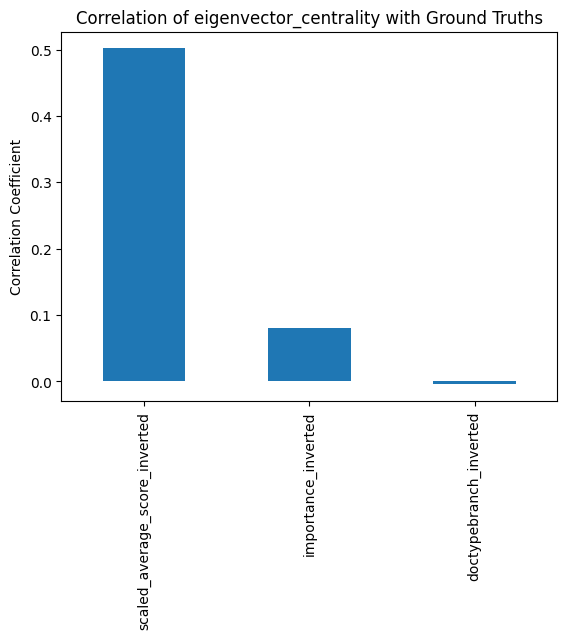

scaled_average_score_inverted    0.501611
importance_inverted              0.080909
doctypebranch_inverted          -0.004515
Name: eigenvector_centrality, dtype: float64


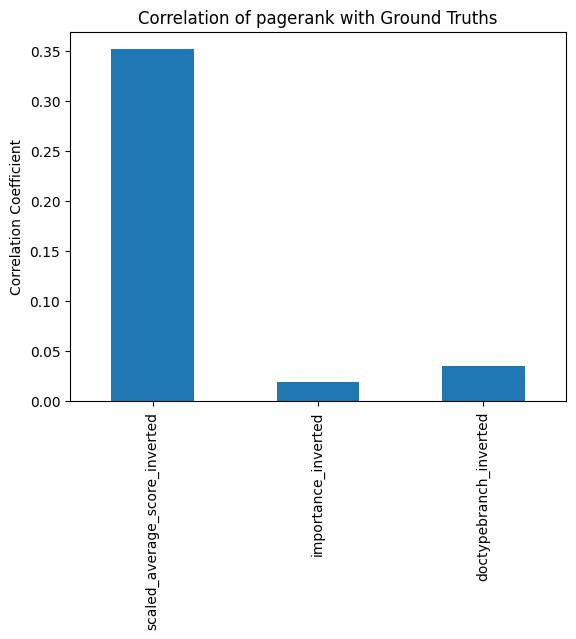

scaled_average_score_inverted    0.351812
importance_inverted              0.019212
doctypebranch_inverted           0.035327
Name: pagerank, dtype: float64


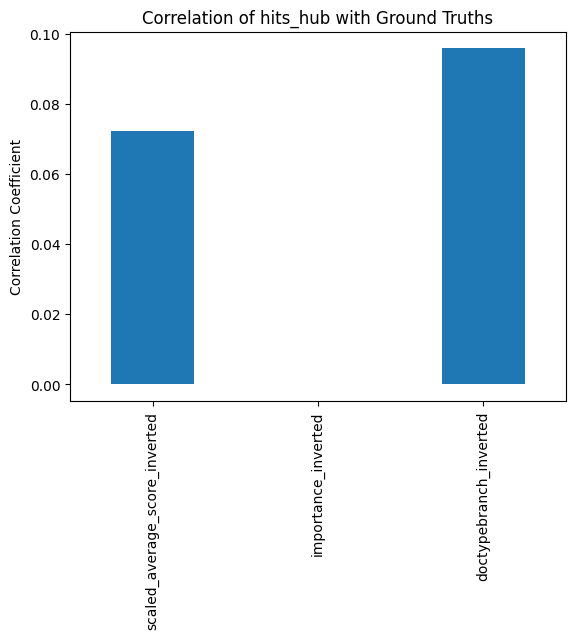

scaled_average_score_inverted    0.072315
importance_inverted             -0.000033
doctypebranch_inverted           0.095889
Name: hits_hub, dtype: float64


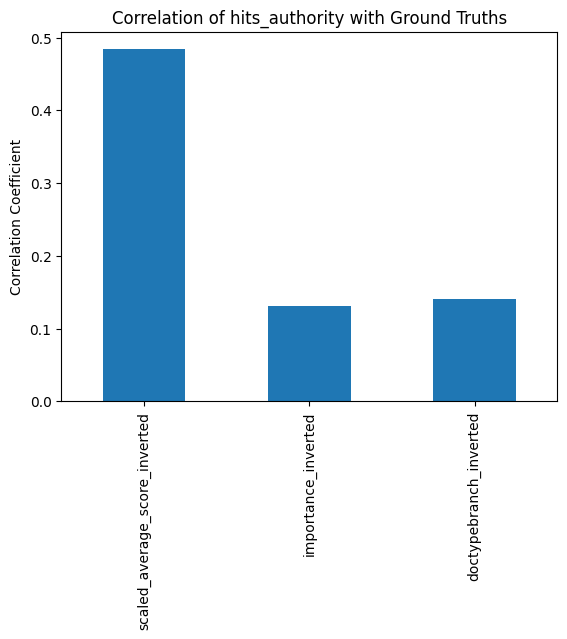

scaled_average_score_inverted    0.483916
importance_inverted              0.131120
doctypebranch_inverted           0.140798
Name: hits_authority, dtype: float64


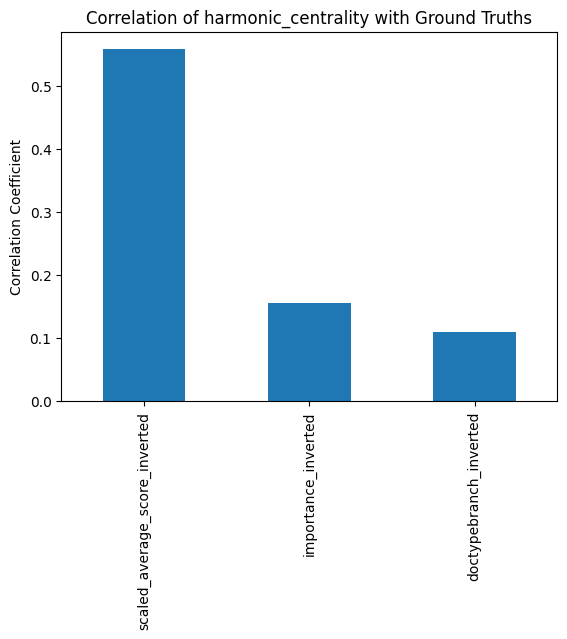

scaled_average_score_inverted    0.557815
importance_inverted              0.155323
doctypebranch_inverted           0.110360
Name: harmonic_centrality, dtype: float64


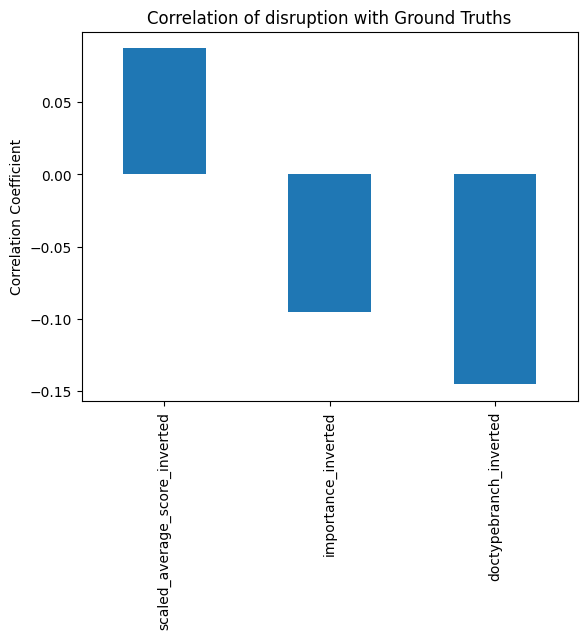

scaled_average_score_inverted    0.087235
importance_inverted             -0.095524
doctypebranch_inverted          -0.145496
Name: disruption, dtype: float64


In [33]:

# Invert the ground truth values to make the interpretation more intuitive
# max_value - current_value or 1 / current_value
# Assuming 'importance' and 'doctypebranch' have their minimum value as 1 (most important)

# Subtract from max_value
max_importance = merged_df['importance'].max()
max_doctypebranch = merged_df['doctypebranch'].max()

merged_df['importance_inverted'] = max_importance - merged_df['importance']
merged_df['doctypebranch_inverted'] = max_doctypebranch - merged_df['doctypebranch']

# scaled_average_score is already scaled in reverse, you might need to invert it as well
max_scaled_average_score = merged_df['scaled_average_score'].max()
merged_df['scaled_average_score_inverted'] = max_scaled_average_score - merged_df['scaled_average_score']


# Select only numeric columns for correlation calculation
numeric_cols = merged_df.select_dtypes(include=[float, int]).columns
print("Columns in merged_df:", merged_df.columns)

# List of all ground truths and centrality measures for correlation
# Assuming the scales are inverted, you need to interpret correlations accordingly
ground_truths = ['scaled_average_score', 'importance', 'doctypebranch']
# List of inverted ground truths
ground_truths_inverted = ['scaled_average_score_inverted', 'importance_inverted', 'doctypebranch_inverted']

centralities = ['degree_centrality', 'in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 'core_number', 
                'relative_in_degree_centrality', 'eigenvector_centrality', 
                'pagerank', 'hits_hub', 'hits_authority', 'harmonic_centrality', 'disruption']

# Calculate and plot correlations for each centrality with all ground truths
for centrality in centralities:
    if centrality in numeric_cols:
        # Calculate correlation between the current centrality and all ground truths
        correlation_results = merged_df[ground_truths_inverted + [centrality]].corr()[centrality][ground_truths_inverted]
        
        # Plot the correlation results
        correlation_results.plot(kind='bar', title=f'Correlation of {centrality} with Ground Truths')
        plt.ylabel('Correlation Coefficient')
        plt.show()
        
        # Print the correlation results for interpretation
        print(correlation_results)
    else:
        print(f"Centrality measure '{centrality}' is not numeric or not found in the DataFrame.")


# Draw Graphs

In [34]:
def prep_data(df: pd.DataFrame, include: list) -> pd.DataFrame:
    """
    Prepare the dataset by selecting the appropriate columns and filtering out rows with uncomputed metric values.
    
    :param df: The DataFrame to process.
    :param include: Columns to include.
    :return: The processed DataFrame.
    """
    headers = include + ['ecli']  # Ensure essential columns are included
    headers = list(set(headers))  # Removing duplicates

    data = df[headers]

    # Filter out rows with uncomputed metric values (-2)
    metric_column = include[-1]
    data = data[data[metric_column] >= -1]

    return data

def plot_graphs(df, metrics, proxies, graphs_path):
    x_limits = {}  # Dictionary to store x-axis limits for each metric

    # First pass: Determine global x-axis limits
    for metric in metrics:
        x_values = []
        for proxy in proxies:
            include = [proxy, metric]
            data = prep_data(df, include)
            x_values.extend(data[metric].tolist())
        x_limits[metric] = (min(x_values), max(x_values))

    # Second pass: Generate plots with consistent x-axis
    for proxy in proxies:
        for metric in metrics:
            include = [proxy, metric]
            data = prep_data(df, include)

            x_header = metric
            y_header = proxy
            x, y = list(data[x_header]), list(data[y_header])
            categories = list(set(y))
            categories.sort()
            num_categories, num_instances = len(categories), len(x)
            y_instances = [[] for _ in range(num_categories)]
            for category_no in range(num_categories):
                for instance_no in range(num_instances):
                    if y[instance_no] == categories[category_no]:
                        y_instances[category_no].append(x[instance_no])
            x = [statistics.mean(y_instances[category_no]) for category_no in range(num_categories)]
            y = categories

            # Draw graph
            title = f"{metric.capitalize()} vs Average {y_header.capitalize()}"
            plt.suptitle(title, fontsize=22)
            plt.xlabel(f"{metric.capitalize()}", fontsize=22)
            plt.ylabel(f"{y_header.capitalize()}", fontsize=22)
            plt.yticks(categories, fontsize=16)

            # Calculate error bars
            stds = [statistics.stdev(y_instances[category_no]) for category_no in range(num_categories)]
            plt.errorbar(x, y, xerr=stds, fmt='o')

            # Set consistent x-axis limits
            plt.xlim(x_limits[metric])

            # Save figure
            plt.savefig(graphs_path + f"{title}.png")
            plt.clf()


def plot_consistent_graphs(df, metrics, proxies, graphs_path):
    global_x_values = []

    # First pass: Collect x-values across all metrics and proxies
    for metric in metrics:
        for proxy in proxies:
            include = [proxy, metric]
            data = prep_data(df, include)
            global_x_values.extend(data[metric].tolist())

    # Calculate 1st and 99th percentiles to avoid outliers
    x_min, x_max = np.percentile(global_x_values, [1, 99])

    # Second pass: Generate plots with consistent x-axis across all graphs
    for proxy in proxies:
        for metric in metrics:
            include = [proxy, metric]
            data = prep_data(df, include)

            x_header = metric
            y_header = proxy
            x, y = list(data[x_header]), list(data[y_header])
            categories = list(set(y))
            categories.sort()
            num_categories, num_instances = len(categories), len(x)
            y_instances = [[] for _ in range(num_categories)]
            for category_no in range(num_categories):
                for instance_no in range(num_instances):
                    if y[instance_no] == categories[category_no]:
                        y_instances[category_no].append(x[instance_no])
            x = [statistics.mean(y_instances[category_no]) for category_no in range(num_categories)]
            y = categories

            # Draw graph
            title = f"{metric.capitalize()} vs Average {y_header.capitalize()}"
            plt.suptitle(title, fontsize=22)
            plt.xlabel(f"{metric.capitalize()}", fontsize=22)
            plt.ylabel(f"{y_header.capitalize()}", fontsize=22)
            plt.yticks(categories, fontsize=16)

            # Calculate error bars
            stds = [statistics.stdev(y_instances[category_no]) for category_no in range(num_categories)]
            plt.errorbar(x, y, xerr=stds, fmt='o')

            # Set consistent x-axis limits based on percentiles
            plt.xlim(x_min, x_max)

            # Save figure
            plt.savefig(graphs_path + f"{title}.png")
            plt.clf()

# Define all metrics and proxies based on your previous code

metrics = CENTRALITIES

proxies = GROUND_TRUTHS
# Plot graphs
plot_graphs(merged_df, metrics, proxies, '../data/graphs/')

# Plot consistent graphs
plot_consistent_graphs(merged_df, metrics, proxies, '../data/consistent_graphs/')

<Figure size 640x480 with 0 Axes>

# Finding Candidate Centralities in Tandem
#### 1. `find_best_centralities_for_joint_measure`

**Purpose**:  
This algorithm identifies two centralities that can be used together to better predict the importance of cases. It does so by analyzing the correlation between each centrality and a specific ground truth.

**How It Works**:
- The algorithm takes a DataFrame containing all centralities and ground truths, along with a specified ground truth column and a list of centrality columns.
- It calculates the correlation matrix between the specified ground truth and all the centralities provided.
- From the correlation matrix:
  - It selects the centrality with the highest positive correlation with the ground truth. This centrality is expected to predict higher importance cases well.
  - It also selects the centrality with the highest negative correlation with the ground truth. This centrality is expected to predict lower importance cases well.
- These two centralities are considered complementary because one performs well in predicting high importance, and the other performs well in predicting low importance.
- The function returns a tuple containing the names of these two centralities.

**Parameters**:
- `merged_df` (pd.DataFrame): The DataFrame containing all centralities and ground truths.
- `ground_truth` (str): The ground truth column name for which the correlations are calculated.
- `centralities` (list): A list of centrality column names to be considered.

**Returns**:  
A tuple containing the names of the best positive and best negative correlating centralities.

#### 2. `create_joint_centrality`

**Purpose**:  
This algorithm creates a new "joint centrality" measure by combining two selected centralities. The idea is that by combining two complementary centralities, you can create a more balanced and accurate predictor of case importance.

**How It Works**:
- The algorithm takes the DataFrame containing the centralities, along with the names of two centralities that you wish to combine.
- It then computes the joint centrality as a weighted sum of the two selected centralities. By default, both centralities are weighted equally (0.5 each), but these weights can be adjusted based on the desired emphasis.
- The resulting joint centrality is returned as a pandas Series, which can then be added back to the DataFrame or used for further analysis.

**Parameters**:
- `merged_df` (pd.DataFrame): The DataFrame containing all centralities.
- `centrality_1` (str): The name of the first centrality to be combined.
- `centrality_2` (str): The name of the second centrality to be combined.

**Returns**:  
A pandas Series containing the joint centrality measure.

In [35]:
def find_best_centralities_for_joint_measure(merged_df: pd.DataFrame, ground_truth: str, centralities: list) -> tuple:
    """
    Find two centralities that complement each other in predicting the importance of cases.
    
    :param merged_df: The DataFrame containing all centralities and ground truths.
    :param ground_truth: The ground truth column name.
    :param centralities: List of centrality columns to consider.
    :return: A tuple of two centralities that complement each other.
    """
    # Calculate correlations between each centrality and the ground truth
    correlation_matrix = merged_df[centralities + [ground_truth]].corr()
    ground_truth_correlations = correlation_matrix[ground_truth][centralities]

    # Select the centrality with the highest positive correlation
    best_positive_centrality = ground_truth_correlations.idxmax()
    best_positive_value = ground_truth_correlations.max()

    # Select the centrality with the highest negative correlation
    best_negative_centrality = ground_truth_correlations.idxmin()
    best_negative_value = ground_truth_correlations.min()

    print(f"Best positive correlation for {ground_truth}: {best_positive_centrality} with {best_positive_value}")
    print(f"Best negative correlation for {ground_truth}: {best_negative_centrality} with {best_negative_value}")
    
    return best_positive_centrality, best_negative_centrality

def create_joint_centrality(merged_df: pd.DataFrame, centrality_1: str, centrality_2: str) -> pd.Series:
    """
    Create a joint centrality measure by combining two centralities.
    
    :param merged_df: The DataFrame containing all centralities.
    :param centrality_1: The first centrality to use.
    :param centrality_2: The second centrality to use.
    :return: A pandas Series with the joint centrality measure.
    """
    # You can use a weighted sum, for example, or simply add the two centralities together
    weight_1 = 0.5
    weight_2 = 0.5

    joint_centrality = (weight_1 * merged_df[centrality_1]) + (weight_2 * merged_df[centrality_2])
    
    return joint_centrality

def create_rule_based_joint_centrality(merged_df: pd.DataFrame, centrality_1: str, centrality_2: str) -> pd.Series:
    """
    Create a joint centrality measure based on rule-based combination of two centralities.
    
    :param merged_df: The DataFrame containing all centralities.
    :param centrality_1: The first centrality to be combined, typically better for predicting higher importance.
    :param centrality_2: The second centrality to be combined, typically better for predicting lower importance.
    :return: A pandas Series with the joint centrality measure.
    """
    # Determine a threshold for centrality_1 based on its median
    threshold = merged_df[centrality_1].median()

    # Apply the rule-based logic
    joint_centrality = np.where(
        merged_df[centrality_1] >= threshold,  # If centrality_1 is above the threshold
        merged_df[centrality_1],  # Use centrality_1 value
        merged_df[centrality_2]  # Otherwise, use centrality_2 value
    )
    
    return pd.Series(joint_centrality, index=merged_df.index)

# Define centralities list based on your previous data
centralities = [
    "degree_centrality", "in_degree_centrality", "out_degree_centrality", 
    "betweenness_centrality", "closeness_centrality", "core_number", 
    "relative_in_degree_centrality", "eigenvector_centrality", 
    "pagerank", "hits_hub", "hits_authority", "harmonic_centrality", 
    "disruption"
]

# List of ground truths to consider
ground_truths = ["importance_inverted", "doctypebranch_inverted", "scaled_average_score"]

# Dictionary to store joint centralities for each ground truth
joint_centralities = {}

for ground_truth in ground_truths:
    # Find the best two centralities for the current ground truth
    best_positive, best_negative = find_best_centralities_for_joint_measure(merged_df, ground_truth, centralities)

    # Create the joint centrality measure for this ground truth
    joint_centrality_name = f'joint_centrality_{ground_truth}'
    merged_df[joint_centrality_name] = create_joint_centrality(merged_df, best_positive, best_negative)
    
    # Store the joint centrality in the dictionary
    joint_centralities[ground_truth] = joint_centrality_name

    # Output the joint centrality measure for this ground truth
    print(f"\nJoint Centrality for {ground_truth}:")
    print(merged_df[[joint_centrality_name, best_positive, best_negative]].head())

# Output the names of the created joint centralities
print("\nCreated Joint Centralities:")
for ground_truth, centrality_name in joint_centralities.items():
    print(f"{ground_truth}: {centrality_name}")

Best positive correlation for importance_inverted: betweenness_centrality with 0.3008909526855447
Best negative correlation for importance_inverted: disruption with -0.09552412105143974

Joint Centrality for importance_inverted:
   joint_centrality_importance_inverted  betweenness_centrality  disruption
0                              0.203611                0.000246    0.406977
1                              0.214286                0.000001    0.428571
2                              0.121480                0.000002    0.242958
3                              0.107657                0.000037    0.215278
4                              0.500000                0.000000    1.000000
Best positive correlation for doctypebranch_inverted: betweenness_centrality with 0.327437264552485
Best negative correlation for doctypebranch_inverted: disruption with -0.14549551366134628

Joint Centrality for doctypebranch_inverted:
   joint_centrality_doctypebranch_inverted  betweenness_centrality  disruption

# Correlating Composite Metrics

Joint Centralities: {'importance_inverted': 'joint_centrality_importance_inverted', 'doctypebranch_inverted': 'joint_centrality_doctypebranch_inverted', 'scaled_average_score': 'joint_centrality_scaled_average_score'}
Ground Truths: ['scaled_average_score', 'importance_inverted', 'doctypebranch_inverted']


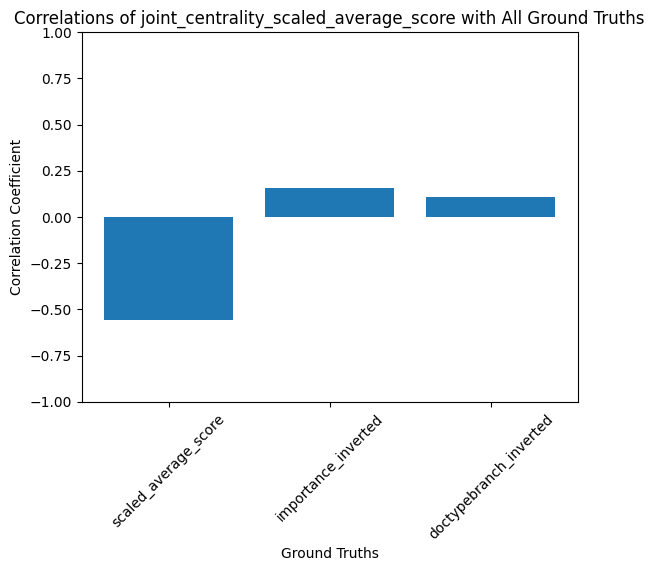

Correlation between joint_centrality_scaled_average_score and scaled_average_score: -0.5578168366907453
Correlation between joint_centrality_scaled_average_score and importance_inverted: 0.1553276821207013
Correlation between joint_centrality_scaled_average_score and doctypebranch_inverted: 0.11036465762014777


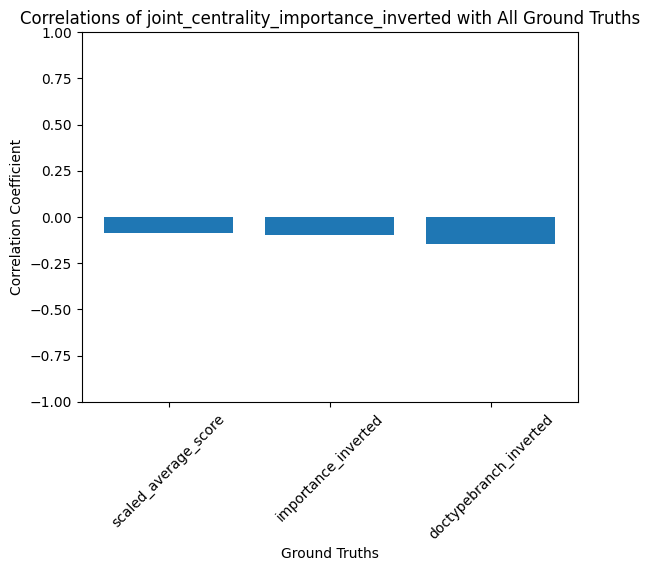

Correlation between joint_centrality_importance_inverted and scaled_average_score: -0.08750891214679511
Correlation between joint_centrality_importance_inverted and importance_inverted: -0.09496012138322105
Correlation between joint_centrality_importance_inverted and doctypebranch_inverted: -0.14489296142769842


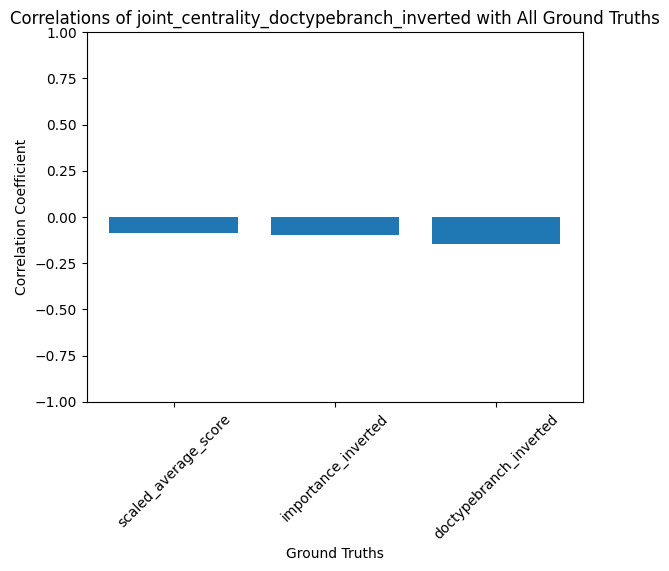

Correlation between joint_centrality_doctypebranch_inverted and scaled_average_score: -0.08750891214679511
Correlation between joint_centrality_doctypebranch_inverted and importance_inverted: -0.09496012138322105
Correlation between joint_centrality_doctypebranch_inverted and doctypebranch_inverted: -0.14489296142769842


In [36]:
# List of ground truths with the inverted scale
ground_truths_inverted = ['scaled_average_score', 'importance_inverted', 'doctypebranch_inverted']

# Function to calculate and plot correlations for joint centralities with all ground truths
def plot_joint_centrality_correlations(merged_df: pd.DataFrame, joint_centralities: dict, ground_truths_inverted: list):
    """
    Plot correlations between joint centralities and all ground truths.
    
    :param merged_df: The DataFrame containing all data.
    :param joint_centralities: Dictionary mapping inverted ground truths to their joint centralities.
    :param ground_truths_inverted: List of inverted ground truths to consider.
    """
    # Describe the parameters for logging
    print(f"Joint Centralities: {joint_centralities}")
    print(f"Ground Truths: {ground_truths_inverted}")
    

    for inverted_ground_truth in ground_truths_inverted:
        joint_centrality_name = joint_centralities[inverted_ground_truth]

        # Calculate correlations between the joint centrality and all ground truths
        correlations = []
        for gt in ground_truths_inverted:
            correlation = merged_df[[joint_centrality_name, gt]].corr().iloc[0, 1]
            correlations.append(correlation)

        # Plot the correlation results
        plt.bar(ground_truths_inverted, correlations)
        plt.title(f'Correlations of {joint_centrality_name} with All Ground Truths')
        plt.ylabel('Correlation Coefficient')
        plt.xlabel('Ground Truths')
        plt.ylim(-1, 1)
        plt.xticks(rotation=45)
        plt.show()
        
        # Print the correlation results for interpretation
        for gt, corr in zip(ground_truths_inverted, correlations):
            print(f"Correlation between {joint_centrality_name} and {gt}: {corr}")

# Plot the correlations for each joint centrality with all ground truths
plot_joint_centrality_correlations(merged_df, joint_centralities, ground_truths_inverted)


# Finding Best Centralities for Joint Metric
Second attempt

Noticed:
- Relying on a single centrality always outperforms the combination of the positive and negative centralities
- Need to introduce normalization

Best positive correlation for importance: disruption with 0.09552412105143956
Best negative correlation for importance: betweenness_centrality with -0.30089095268554483

Best Joint Centrality for importance: joint_centrality_importance_w1.00_w0.00
Best Weights: (1.0, 0.0)
Best Correlation: 0.09552412105143956
Best positive correlation for doctypebranch: disruption with 0.14549551366134622
Best negative correlation for doctypebranch: betweenness_centrality with -0.327437264552485

Best Joint Centrality for doctypebranch: joint_centrality_doctypebranch_w1.00_w0.00
Best Weights: (1.0, 0.0)
Best Correlation: 0.14549551366134622
Best positive correlation for scaled_average_score: out_degree_centrality with 0.06780099904283486
Best negative correlation for scaled_average_score: harmonic_centrality with -0.5578148391127518

Best Joint Centrality for scaled_average_score: joint_centrality_scaled_average_score_w1.00_w0.00
Best Weights: (1.0, 0.0)
Best Correlation: 0.06780099904283486


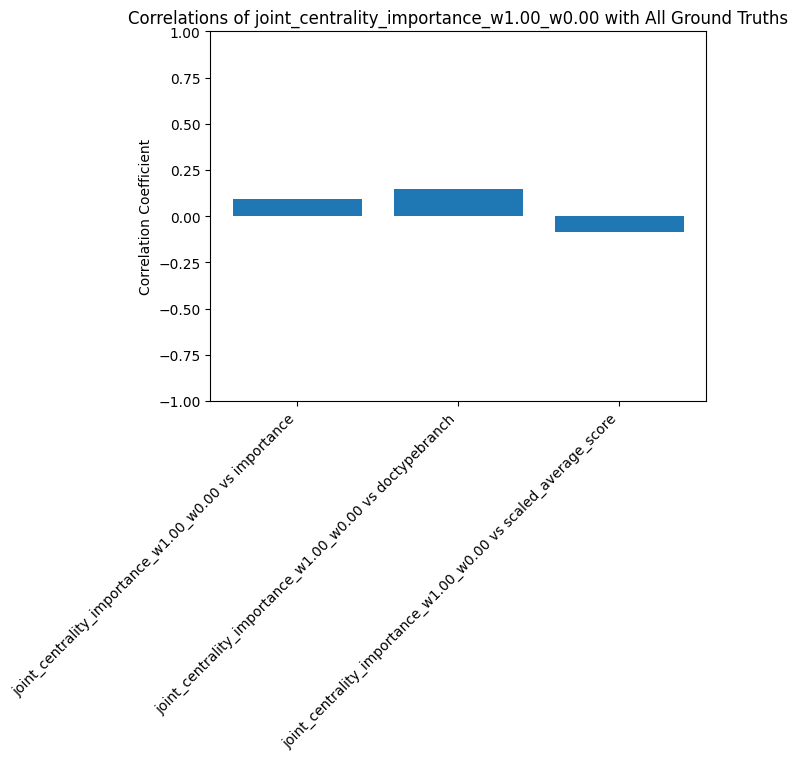

Correlation between joint_centrality_importance_w1.00_w0.00 vs importance: 0.09552412105143956
Correlation between joint_centrality_importance_w1.00_w0.00 vs doctypebranch: 0.14549551366134622
Correlation between joint_centrality_importance_w1.00_w0.00 vs scaled_average_score: -0.08723471458248058


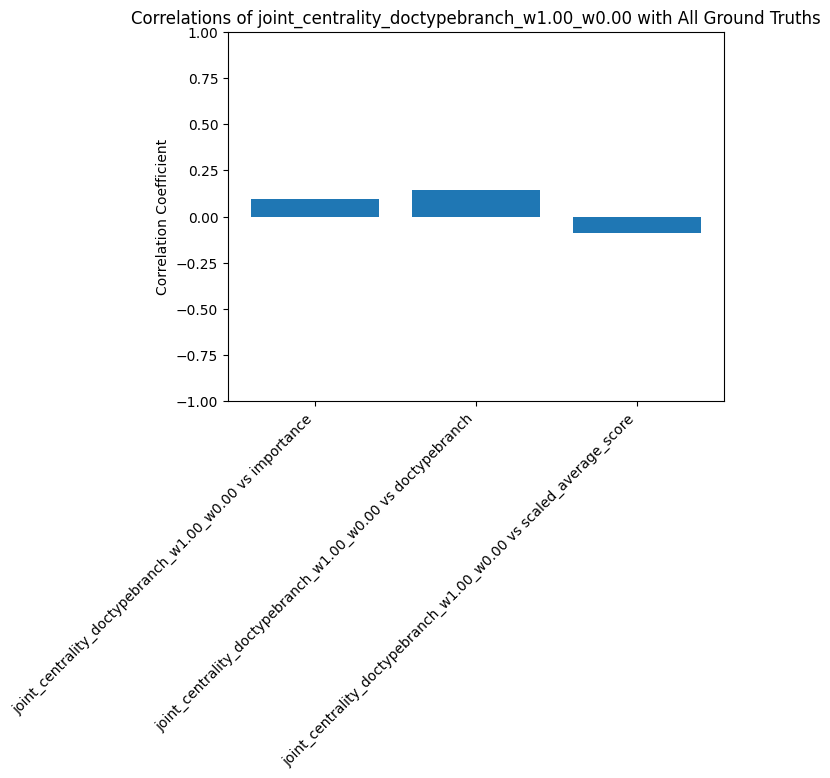

Correlation between joint_centrality_doctypebranch_w1.00_w0.00 vs importance: 0.09552412105143956
Correlation between joint_centrality_doctypebranch_w1.00_w0.00 vs doctypebranch: 0.14549551366134622
Correlation between joint_centrality_doctypebranch_w1.00_w0.00 vs scaled_average_score: -0.08723471458248058


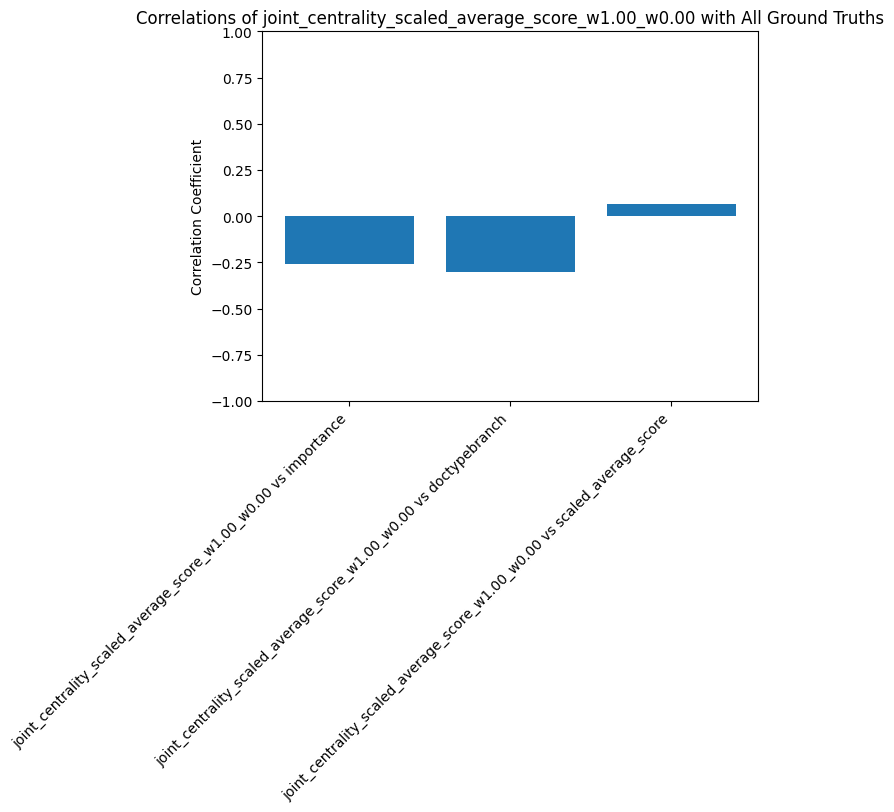

Correlation between joint_centrality_scaled_average_score_w1.00_w0.00 vs importance: -0.2585000303562468
Correlation between joint_centrality_scaled_average_score_w1.00_w0.00 vs doctypebranch: -0.30059803478023883
Correlation between joint_centrality_scaled_average_score_w1.00_w0.00 vs scaled_average_score: 0.06780099904283486


In [37]:
def find_best_centralities_for_joint_measure(merged_df: pd.DataFrame, ground_truth: str, centralities: list) -> tuple:
    """
    Find two centralities that complement each other in predicting the importance of cases.
    
    :param merged_df: The DataFrame containing all centralities and ground truths.
    :param ground_truth: The ground truth column name.
    :param centralities: List of centrality columns to consider.
    :return: A tuple of two centralities that complement each other.
    """
    # Calculate correlations between each centrality and the ground truth
    correlation_matrix = merged_df[centralities + [ground_truth]].corr()
    ground_truth_correlations = correlation_matrix[ground_truth][centralities]

    # Select the centrality with the highest positive correlation
    best_positive_centrality = ground_truth_correlations.idxmax()
    best_positive_value = ground_truth_correlations.max()

    # Select the centrality with the highest negative correlation
    best_negative_centrality = ground_truth_correlations.idxmin()
    best_negative_value = ground_truth_correlations.min()

    print(f"Best positive correlation for {ground_truth}: {best_positive_centrality} with {best_positive_value}")
    print(f"Best negative correlation for {ground_truth}: {best_negative_centrality} with {best_negative_value}")
    
    return best_positive_centrality, best_negative_centrality

def create_weighted_joint_centrality(merged_df: pd.DataFrame, centrality_1: str, centrality_2: str, weight_1: float, weight_2: float) -> pd.Series:
    """
    Create a joint centrality measure by combining two centralities using specified weights.
    
    :param merged_df: The DataFrame containing all centralities.
    :param centrality_1: The first centrality to use.
    :param centrality_2: The second centrality to use.
    :param weight_1: The weight for the first centrality.
    :param weight_2: The weight for the second centrality.
    :return: A pandas Series with the joint centrality measure.
    """
    joint_centrality = (weight_1 * merged_df[centrality_1]) + (weight_2 * merged_df[centrality_2])
    
    return joint_centrality

# Define centralities list based on your previous data
centralities = [
    "degree_centrality", "in_degree_centrality", "out_degree_centrality", 
    "betweenness_centrality", "closeness_centrality", "core_number", 
    "relative_in_degree_centrality", "eigenvector_centrality", 
    "pagerank", "hits_hub", "hits_authority", "harmonic_centrality", 
    "disruption"
]

# List of ground truths to consider
ground_truths = ["importance", "doctypebranch", "scaled_average_score"]

# Loop through each ground truth
for ground_truth in ground_truths:
    # Find the best two centralities for the current ground truth
    best_positive, best_negative = find_best_centralities_for_joint_measure(merged_df, ground_truth, centralities)

    # Initialize variables to track the best correlation and corresponding weights
    best_correlation = -np.inf
    best_weights = (0.0, 0.0)
    best_joint_centrality_name = None

    # Loop through weight combinations
    for weight in np.arange(0.0, 1.1, 0.1):
        weight_1 = weight
        weight_2 = 1.0 - weight

        # Create the joint centrality measure for this ground truth
        joint_centrality_name = f'joint_centrality_{ground_truth}_w{weight_1:.2f}_w{weight_2:.2f}'
        merged_df[joint_centrality_name] = create_weighted_joint_centrality(merged_df, best_positive, best_negative, weight_1, weight_2)
        
        # Calculate correlation with the ground truth
        correlation = merged_df[[joint_centrality_name, ground_truth]].corr().iloc[0, 1]
        
        # Update the best correlation and weights if this one is better
        if correlation > best_correlation:
            best_correlation = correlation
            best_weights = (weight_1, weight_2)
            best_joint_centrality_name = joint_centrality_name

    # Output the best joint centrality measure and its correlation for this ground truth
    print(f"\nBest Joint Centrality for {ground_truth}: {best_joint_centrality_name}")
    print(f"Best Weights: {best_weights}")
    print(f"Best Correlation: {best_correlation}")

def plot_best_correlations(merged_df: pd.DataFrame, ground_truths: list, best_joint_centrality_names: list):
    for ground_truth, joint_centrality_name in zip(ground_truths, best_joint_centrality_names):
        correlations = []
        labels = []

        # Calculate correlation with the primary ground truth and the other two ground truths
        for gt in ground_truths:
            correlation = merged_df[[joint_centrality_name, gt]].corr().iloc[0, 1]
            correlations.append(correlation)
            labels.append(f"{joint_centrality_name} vs {gt}")

        # Plot the correlations
        plt.bar(labels, correlations)
        plt.title(f'Correlations of {joint_centrality_name} with All Ground Truths')
        plt.ylabel('Correlation Coefficient')
        plt.ylim(-1, 1)
        plt.xticks(rotation=45, ha="right")
        plt.show()

        # Print the correlation results for interpretation
        for label, corr in zip(labels, correlations):
            print(f"Correlation between {label}: {corr}")

# Collect the best joint centrality names and plot the results
best_joint_centrality_names = [f'joint_centrality_{gt}_w{best_weights[0]:.2f}_w{best_weights[1]:.2f}' for gt in ground_truths]
plot_best_correlations(merged_df, ground_truths, best_joint_centrality_names)

# Implementing Normalization and Standardization


Best positive correlation for importance_inverted: betweenness_centrality with 0.3008909526855447
Best negative correlation for importance_inverted: disruption with -0.09552412105143974

Best Joint Centrality for importance_inverted: joint_centrality_importance_inverted_w1.00_w0.00
Best Weights: (1.0, 0.0)
Best Correlation: 0.3008909526855445
Best positive correlation for doctypebranch_inverted: betweenness_centrality with 0.32743726455248495
Best negative correlation for doctypebranch_inverted: disruption with -0.1454955136613462

Best Joint Centrality for doctypebranch_inverted: joint_centrality_doctypebranch_inverted_w1.00_w0.00
Best Weights: (1.0, 0.0)
Best Correlation: 0.32743726455248495
Best positive correlation for scaled_average_score: out_degree_centrality with 0.06780099904283486
Best negative correlation for scaled_average_score: harmonic_centrality with -0.5578148391127518

Best Joint Centrality for scaled_average_score: joint_centrality_scaled_average_score_w1.00_w0.00
Be

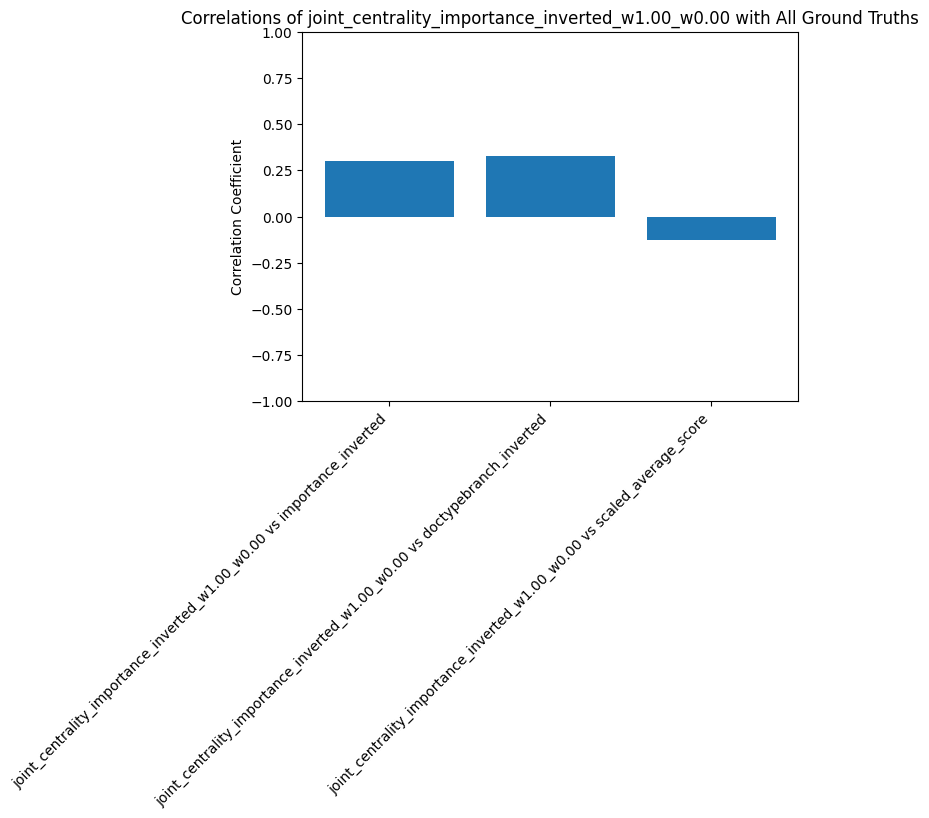

Correlation between joint_centrality_importance_inverted_w1.00_w0.00 vs importance_inverted: 0.3008909526855445
Correlation between joint_centrality_importance_inverted_w1.00_w0.00 vs doctypebranch_inverted: 0.32743726455248495
Correlation between joint_centrality_importance_inverted_w1.00_w0.00 vs scaled_average_score: -0.1278858185544229


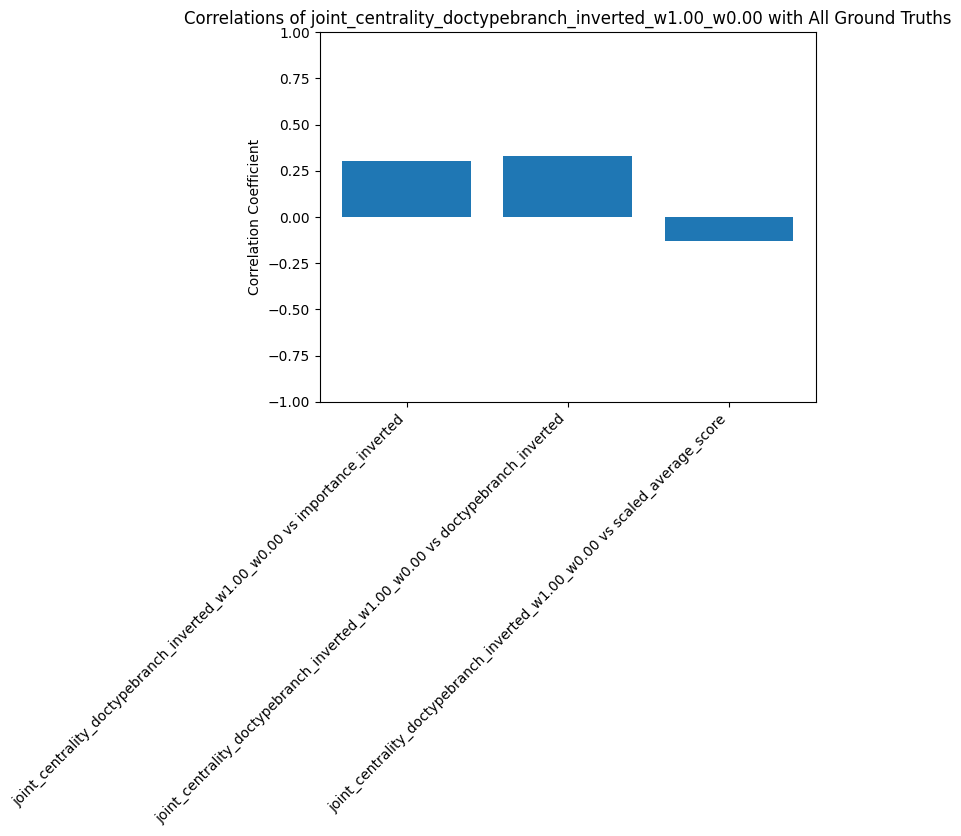

Correlation between joint_centrality_doctypebranch_inverted_w1.00_w0.00 vs importance_inverted: 0.30089095268554444
Correlation between joint_centrality_doctypebranch_inverted_w1.00_w0.00 vs doctypebranch_inverted: 0.32743726455248495
Correlation between joint_centrality_doctypebranch_inverted_w1.00_w0.00 vs scaled_average_score: -0.1278858185544229


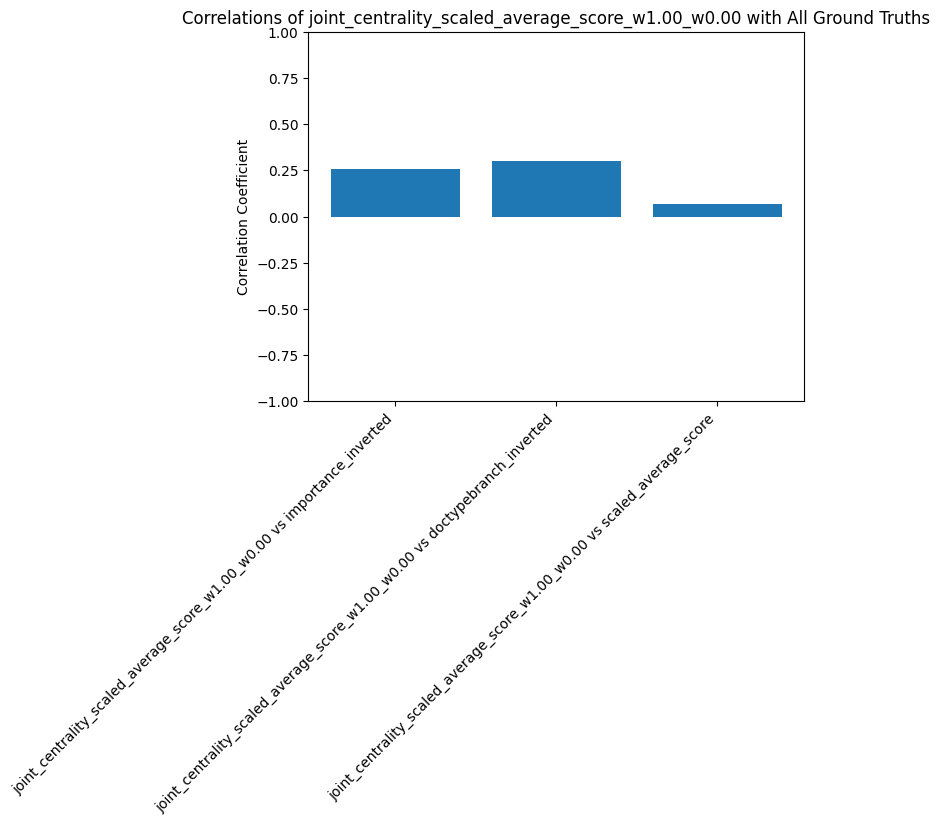

Correlation between joint_centrality_scaled_average_score_w1.00_w0.00 vs importance_inverted: 0.25850003035624736
Correlation between joint_centrality_scaled_average_score_w1.00_w0.00 vs doctypebranch_inverted: 0.30059803478023917
Correlation between joint_centrality_scaled_average_score_w1.00_w0.00 vs scaled_average_score: 0.06780099904283488


In [38]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_centralities(merged_df, centrality_1, centrality_2):
    """
    Normalize the specified centralities to a common scale using StandardScaler.
    
    :param merged_df: The DataFrame containing all centralities.
    :param centrality_1: The first centrality to normalize.
    :param centrality_2: The second centrality to normalize.
    :return: The DataFrame with normalized centralities.
    """
    scaler = StandardScaler()
    merged_df[[centrality_1, centrality_2]] = scaler.fit_transform(merged_df[[centrality_1, centrality_2]])
    return merged_df

def find_best_centralities_for_joint_measure(merged_df: pd.DataFrame, ground_truth: str, centralities: list) -> tuple:
    """
    Find two centralities that complement each other in predicting the importance of cases.
    
    :param merged_df: The DataFrame containing all centralities and ground truths.
    :param ground_truth: The ground truth column name.
    :param centralities: List of centrality columns to consider.
    :return: A tuple of two centralities that complement each other.
    """
    # Calculate correlations between each centrality and the ground truth
    correlation_matrix = merged_df[centralities + [ground_truth]].corr()
    ground_truth_correlations = correlation_matrix[ground_truth][centralities]

    # Select the centrality with the highest positive correlation
    best_positive_centrality = ground_truth_correlations.idxmax()
    best_positive_value = ground_truth_correlations.max()

    # Select the centrality with the highest negative correlation
    best_negative_centrality = ground_truth_correlations.idxmin()
    best_negative_value = ground_truth_correlations.min()

    print(f"Best positive correlation for {ground_truth}: {best_positive_centrality} with {best_positive_value}")
    print(f"Best negative correlation for {ground_truth}: {best_negative_centrality} with {best_negative_value}")
    
    return best_positive_centrality, best_negative_centrality

def create_weighted_joint_centrality(merged_df: pd.DataFrame, centrality_1: str, centrality_2: str, weight_1: float, weight_2: float) -> pd.Series:
    """
    Create a joint centrality measure by combining two centralities using specified weights.
    
    :param merged_df: The DataFrame containing all centralities.
    :param centrality_1: The first centrality to use.
    :param centrality_2: The second centrality to use.
    :param weight_1: The weight for the first centrality.
    :param weight_2: The weight for the second centrality.
    :return: A pandas Series with the joint centrality measure.
    """
    joint_centrality = (weight_1 * merged_df[centrality_1]) + (weight_2 * merged_df[centrality_2])
    
    return joint_centrality

# Define centralities list based on your previous data
centralities = [
    "degree_centrality", "in_degree_centrality", "out_degree_centrality", 
    "betweenness_centrality", "closeness_centrality", "core_number", 
    "relative_in_degree_centrality", "eigenvector_centrality", 
    "pagerank", "hits_hub", "hits_authority", "harmonic_centrality", 
    "disruption"
]

# List of ground truths to consider
ground_truths = ["importance_inverted", "doctypebranch_inverted", "scaled_average_score"]

# Loop through each ground truth
for ground_truth in ground_truths:
    # Find the best two centralities for the current ground truth
    best_positive, best_negative = find_best_centralities_for_joint_measure(merged_df, ground_truth, centralities)

    # Normalize the centralities before combining them
    merged_df = normalize_centralities(merged_df, best_positive, best_negative)

    # Initialize variables to track the best correlation and corresponding weights
    best_correlation = -np.inf
    best_weights = (0.0, 0.0)
    best_joint_centrality_name = None

    # Loop through weight combinations
    for weight in np.arange(0.0, 1.1, 0.1):
        weight_1 = weight
        weight_2 = 1.0 - weight

        # Create the joint centrality measure for this ground truth
        joint_centrality_name = f'joint_centrality_{ground_truth}_w{weight_1:.2f}_w{weight_2:.2f}'
        merged_df[joint_centrality_name] = create_weighted_joint_centrality(merged_df, best_positive, best_negative, weight_1, weight_2)
        
        # Calculate correlation with the ground truth
        correlation = merged_df[[joint_centrality_name, ground_truth]].corr().iloc[0, 1]
        
        # Update the best correlation and weights if this one is better
        if correlation > best_correlation:
            best_correlation = correlation
            best_weights = (weight_1, weight_2)
            best_joint_centrality_name = joint_centrality_name

    # Output the best joint centrality measure and its correlation for this ground truth
    print(f"\nBest Joint Centrality for {ground_truth}: {best_joint_centrality_name}")
    print(f"Best Weights: {best_weights}")
    print(f"Best Correlation: {best_correlation}")

def plot_best_correlations(merged_df: pd.DataFrame, ground_truths: list, best_joint_centrality_names: list):
    for ground_truth, joint_centrality_name in zip(ground_truths, best_joint_centrality_names):
        correlations = []
        labels = []

        # Calculate correlation with the primary ground truth and the other two ground truths
        for gt in ground_truths:
            correlation = merged_df[[joint_centrality_name, gt]].corr().iloc[0, 1]
            correlations.append(correlation)
            labels.append(f"{joint_centrality_name} vs {gt}")

        # Plot the correlations
        plt.bar(labels, correlations)
        plt.title(f'Correlations of {joint_centrality_name} with All Ground Truths')
        plt.ylabel('Correlation Coefficient')
        plt.ylim(-1, 1)
        plt.xticks(rotation=45, ha="right")
        plt.show()

        # Print the correlation results for interpretation
        for label, corr in zip(labels, correlations):
            print(f"Correlation between {label}: {corr}")

# Collect the best joint centrality names and plot the results
best_joint_centrality_names = [f'joint_centrality_{gt}_w{best_weights[0]:.2f}_w{best_weights[1]:.2f}' for gt in ground_truths]
plot_best_correlations(merged_df, ground_truths, best_joint_centrality_names)

# New Ideas
- Interaction Terms
- Non-Linear Combinations

# Visualizing the Distribution


Best positive correlation for importance: disruption with 0.09552412105143966
Best negative correlation for importance: betweenness_centrality with -0.3008909526855445


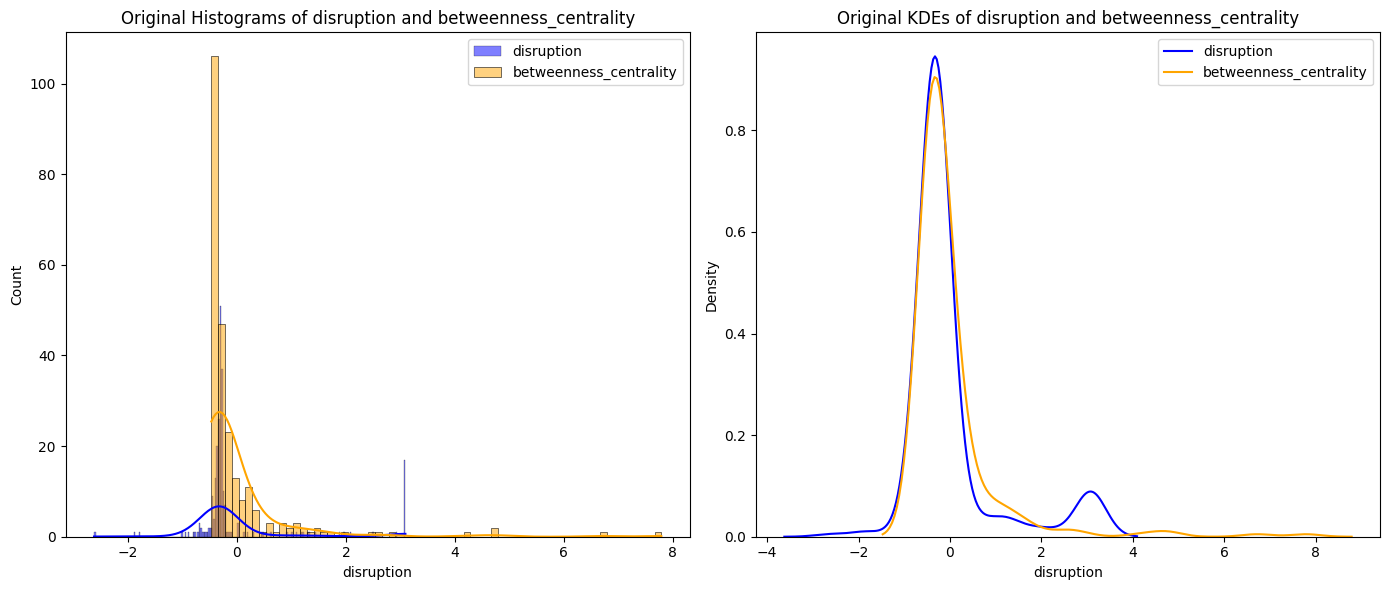

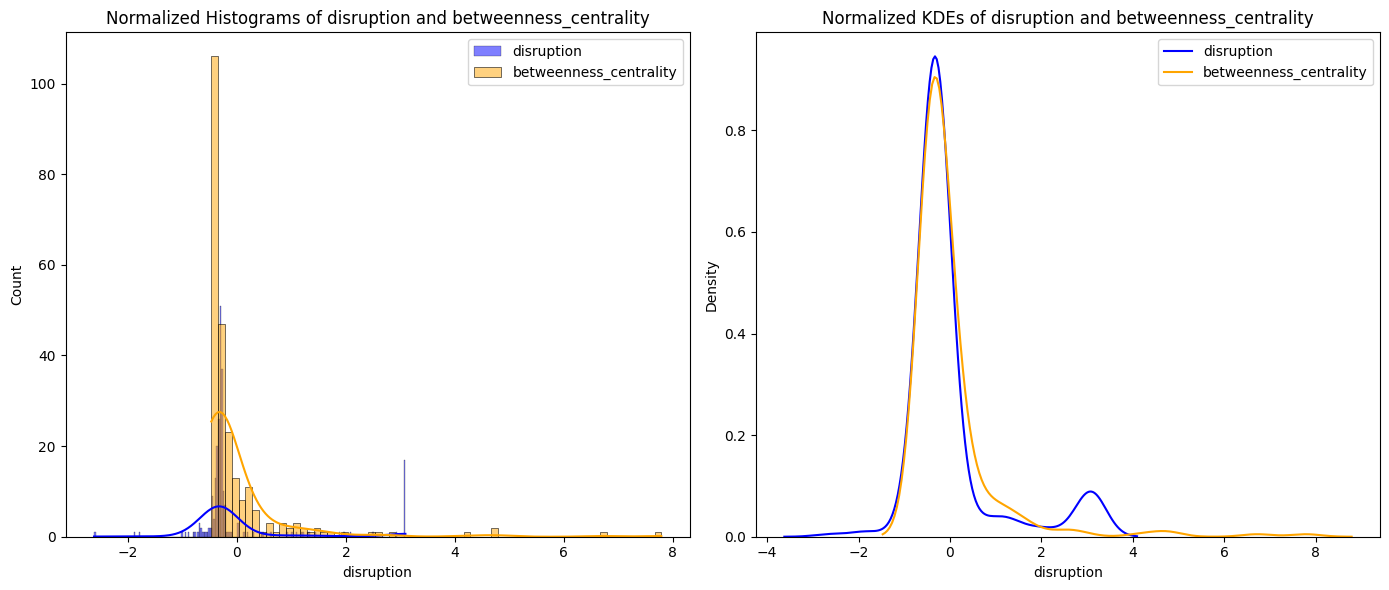

Best positive correlation for scaled_average_score: out_degree_centrality with 0.06780099904283488
Best negative correlation for scaled_average_score: harmonic_centrality with -0.5578148391127518


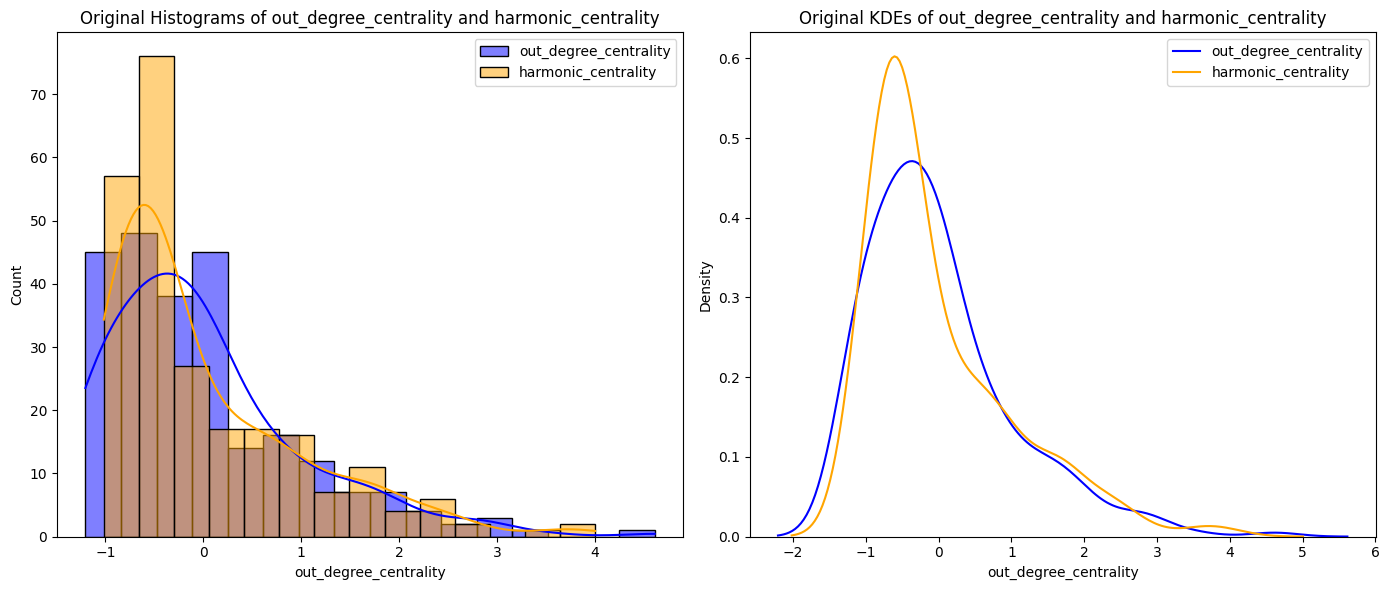

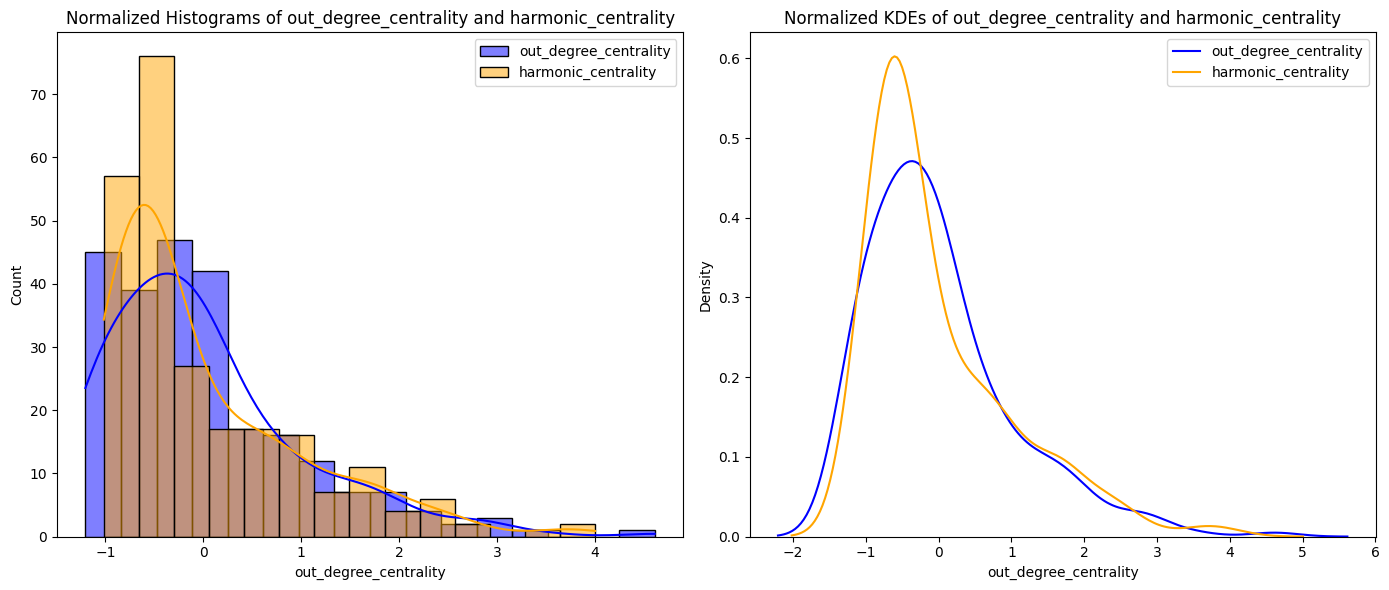

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_centrality_distributions(merged_df: pd.DataFrame, centrality_1: str, centrality_2: str, normalized: bool = False):
    """
    Plot the distributions of two centralities, both as histograms and KDE plots.
    
    :param merged_df: The DataFrame containing the centralities.
    :param centrality_1: The first centrality to plot.
    :param centrality_2: The second centrality to plot.
    :param normalized: A flag indicating whether the centralities have been normalized.
    """
    status = "Normalized" if normalized else "Original"
    
    plt.figure(figsize=(14, 6))
    
    # Plot histograms
    plt.subplot(1, 2, 1)
    sns.histplot(merged_df[centrality_1], kde=True, color='blue', label=centrality_1)
    sns.histplot(merged_df[centrality_2], kde=True, color='orange', label=centrality_2)
    plt.title(f'{status} Histograms of {centrality_1} and {centrality_2}')
    plt.legend()
    
    # Plot KDEs
    plt.subplot(1, 2, 2)
    sns.kdeplot(merged_df[centrality_1], color='blue', label=centrality_1)
    sns.kdeplot(merged_df[centrality_2], color='orange', label=centrality_2)
    plt.title(f'{status} KDEs of {centrality_1} and {centrality_2}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Importance:
best_positive, best_negative = find_best_centralities_for_joint_measure(merged_df, 'importance', centralities)

# Plot distributions before normalization
plot_centrality_distributions(merged_df, best_positive, best_negative, normalized=False)

# Normalize the centralities
merged_df = normalize_centralities(merged_df, best_positive, best_negative)

# Plot distributions after normalization
plot_centrality_distributions(merged_df, best_positive, best_negative, normalized=True)

# Average Score:
best_positive, best_negative = find_best_centralities_for_joint_measure(merged_df, 'scaled_average_score', centralities)

# Plot distributions before normalization
plot_centrality_distributions(merged_df, best_positive, best_negative, normalized=False)

# Normalize the centralities
merged_df = normalize_centralities(merged_df, best_positive, best_negative)

# Plot distributions after normalization
plot_centrality_distributions(merged_df, best_positive, best_negative, normalized=True)

# New Attempt (Error Bars)
Treat the 3 ground truths separately
- Dataset is skewed (uneven number of observations) -> Not looking at the error bars

Steps:
- Looking at the error bars
- Looking at the min error bars for the highest relevance
- Select the one that is best weather something is good at predicting a high score
- Select the one that is best weather it is good at predicting a low score

Suggested approach:
- Set the treshold based on where the error-bar ends
- Rank the cases based on every centrality -> Get comparable measure/ranking
  - Case with highest centrality (i.e.) degree score gets highest rank (1)
  - Case with lowest centrality (i.e) degree score gets lowest rank (i.e. 200)
- Compare the rankings to a new composite ranking

Calculating the ranking
- Look for a cutoff
- Plot error bars
- Look for the centrality that has the lowest error bar at predicting the high relevance of a ground truth
    - Take the lower bound of the error bar (as an initial treshold) -> 
    - Select all cases with (i.e. metric) disruption score of (treshold) or higher
    - Rank the selected cases -> Highest to lowest (i.e. 15 cases, rank 1 has highest disruption, so on)
- Remaining cases, look for the centrality measure that performs best at predicting the lowest relevance score
    - Select all cases with (i.e. metric) disruption score of (treshold) or higher
    - Rank the selected cases -> Highest to lowest (i.e. 185 cases, rank 1 has highest degree, so on)

Evaluate the ranking:
- Correlate all the rankings of all the centrality scores (individual) to the ground truths
- Select the one with the highest negative correlation (if ground truth has inversed scale) -> Yield one centrality measure
- Correlate ranking of the composite measure to the ground truths
- Ending up with 2 correlation coeff (individual metric, and composite) -> Select the one that has the highest corr.

Notes:
- When writing the script, make it easy to transpose the results to a table for the paper
- Correlation coefficients of centrality measures and how they correlate with the ground truth scores
- CSV output

In [40]:
merged_df.describe()
merged_df.head()

,A1,A2,A3,ECLI,total_score,average_score,ecli,importance,doctypebranch,scaled_average_score,...,joint_centrality_doctypebranch_inverted_w0.10_w0.90,joint_centrality_doctypebranch_inverted_w0.20_w0.80,joint_centrality_doctypebranch_inverted_w0.30_w0.70,joint_centrality_doctypebranch_inverted_w0.40_w0.60,joint_centrality_doctypebranch_inverted_w0.50_w0.50,joint_centrality_doctypebranch_inverted_w0.60_w0.40,joint_centrality_doctypebranch_inverted_w0.70_w0.30,joint_centrality_doctypebranch_inverted_w0.80_w0.20,joint_centrality_doctypebranch_inverted_w0.90_w0.10,joint_centrality_doctypebranch_inverted_w1.00_w0.00
0,2,2,2,ECLI:CE:ECHR:1979:0613JUD000683374,6,2.000000,ECLI:CE:ECHR:1979:0613JUD000683374,2,2,0.0,...,0.986521,0.871462,0.756403,0.641344,0.526285,0.411226,0.296167,0.181108,0.066049,-0.049010
1,1,0,0,ECLI:CE:ECHR:1982:0225JUD000751176,1,0.333333,ECLI:CE:ECHR:1982:0225JUD000751176,2,2,2.0,...,1.009862,0.845676,0.681490,0.517304,0.353118,0.188932,0.024746,-0.139440,-0.303626,-0.467812
2,2,2,2,ECLI:CE:ECHR:1982:0923JUD000715175,6,2.000000,ECLI:CE:ECHR:1982:0923JUD000715175,2,2,0.0,...,0.449375,0.347589,0.245804,0.144018,0.042232,-0.059553,-0.161339,-0.263125,-0.364910,-0.466696
3,0,1,2,ECLI:CE:ECHR:1983:1123JUD000891980,3,1.000000,ECLI:CE:ECHR:1983:1123JUD000891980,2,2,1.0,...,0.371711,0.285150,0.198589,0.112028,0.025468,-0.061093,-0.147654,-0.234215,-0.320775,-0.407336
4,2,2,2,ECLI:CE:ECHR:1986:0221JUD000879379,6,2.000000,ECLI:CE:ECHR:1986:0221JUD000879379,2,2,0.0,...,2.735496,2.379329,2.023162,1.666995,1.310828,0.954661,0.598494,0.242327,-0.113840,-0.470007



Analyzing ground truth: importance
Best high centrality for importance: betweenness_centrality
Best low centrality for importance: degree_centrality


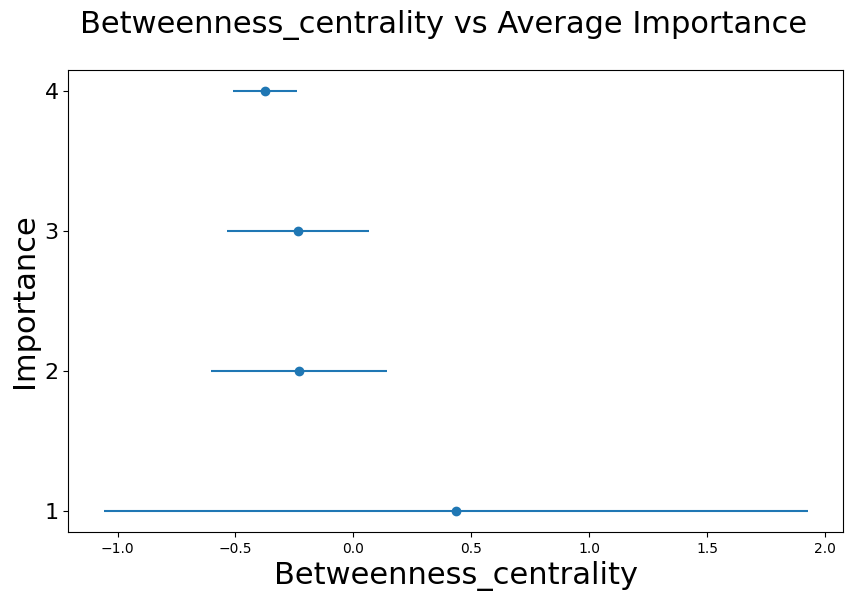

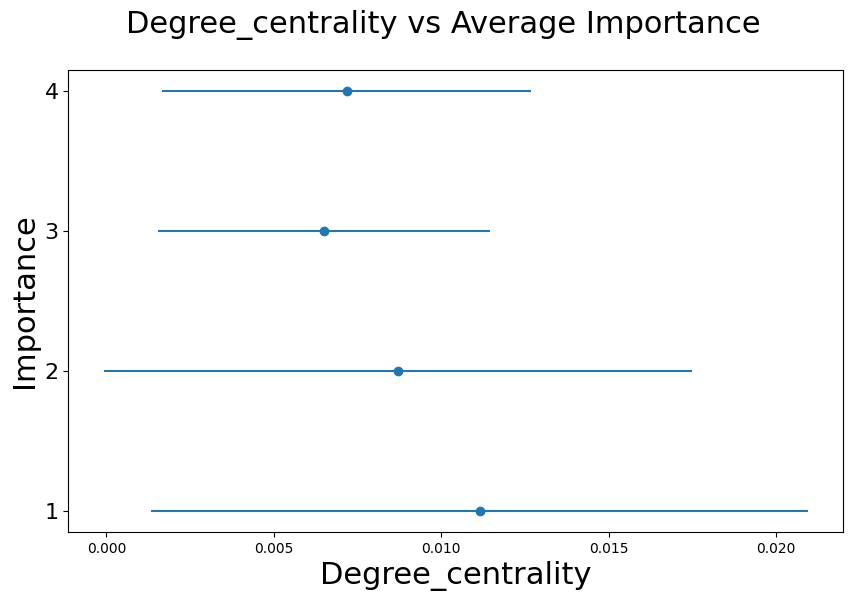


Correlations for importance:
Individual Centrality Correlations:
degree_centrality vs importance: 0.30982888012193516
degree_centrality vs scaled_average_score: 0.383431977048247
degree_centrality vs doctypebranch: 0.35439463789115255
in_degree_centrality vs importance: 0.19869399703629695
in_degree_centrality vs scaled_average_score: 0.44206889527865456
in_degree_centrality vs doctypebranch: 0.2794600290691479
out_degree_centrality vs importance: 0.265680436735234
out_degree_centrality vs scaled_average_score: -0.09833965904309419
out_degree_centrality vs doctypebranch: 0.2805631783177324
betweenness_centrality vs importance: 0.3573197541003978
betweenness_centrality vs scaled_average_score: 0.12006260170018296
betweenness_centrality vs doctypebranch: 0.42562679017218213
closeness_centrality vs importance: 0.17356098567075415
closeness_centrality vs scaled_average_score: 0.4518735214107815
closeness_centrality vs doctypebranch: 0.14138621409208538
core_number vs importance: 0.2728198

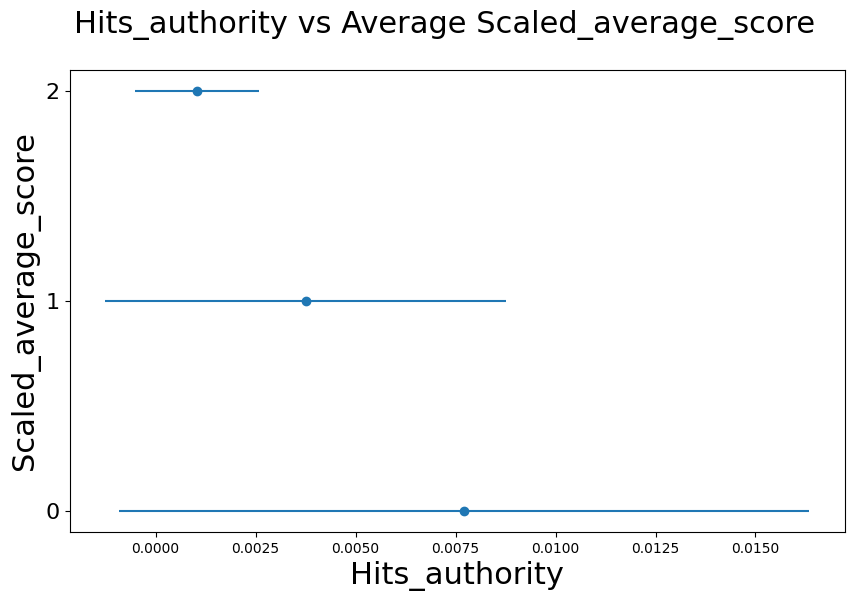

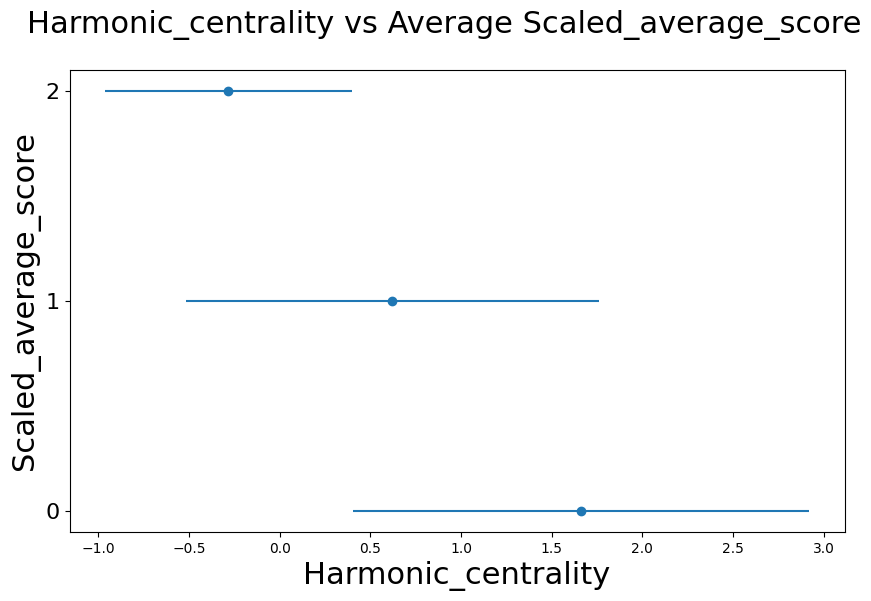


Correlations for scaled_average_score:
Individual Centrality Correlations:
degree_centrality vs importance: 0.30982888012193516
degree_centrality vs scaled_average_score: 0.383431977048247
degree_centrality vs doctypebranch: 0.35439463789115255
in_degree_centrality vs importance: 0.19869399703629695
in_degree_centrality vs scaled_average_score: 0.44206889527865456
in_degree_centrality vs doctypebranch: 0.2794600290691479
out_degree_centrality vs importance: 0.265680436735234
out_degree_centrality vs scaled_average_score: -0.09833965904309419
out_degree_centrality vs doctypebranch: 0.2805631783177324
betweenness_centrality vs importance: 0.3573197541003978
betweenness_centrality vs scaled_average_score: 0.12006260170018296
betweenness_centrality vs doctypebranch: 0.42562679017218213
closeness_centrality vs importance: 0.17356098567075415
closeness_centrality vs scaled_average_score: 0.4518735214107815
closeness_centrality vs doctypebranch: 0.14138621409208538
core_number vs importance:

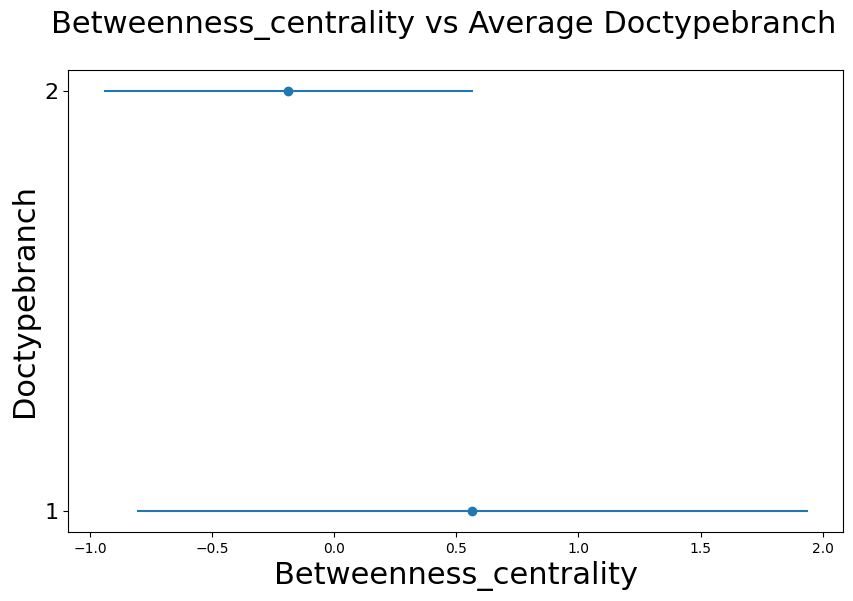

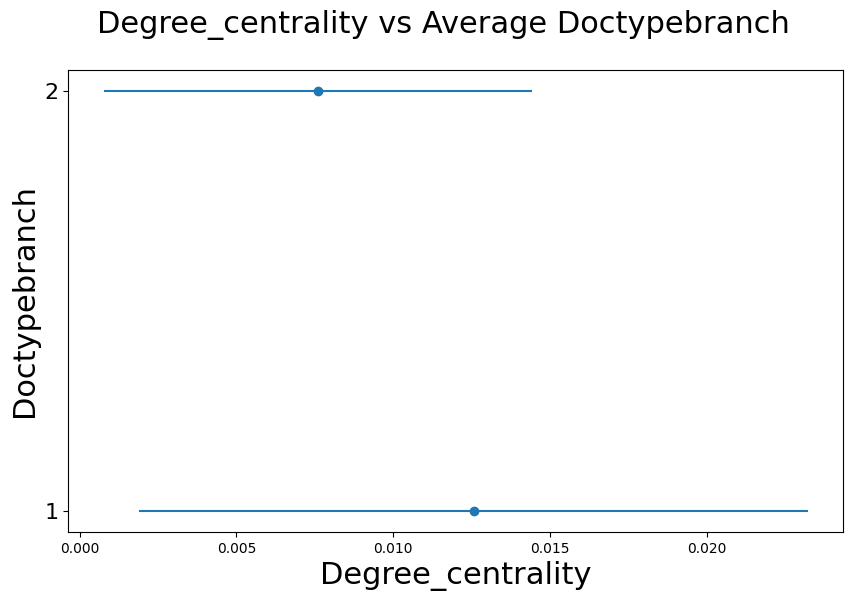


Correlations for doctypebranch:
Individual Centrality Correlations:
degree_centrality vs importance: 0.30982888012193516
degree_centrality vs scaled_average_score: 0.383431977048247
degree_centrality vs doctypebranch: 0.35439463789115255
in_degree_centrality vs importance: 0.19869399703629695
in_degree_centrality vs scaled_average_score: 0.44206889527865456
in_degree_centrality vs doctypebranch: 0.2794600290691479
out_degree_centrality vs importance: 0.265680436735234
out_degree_centrality vs scaled_average_score: -0.09833965904309419
out_degree_centrality vs doctypebranch: 0.2805631783177324
betweenness_centrality vs importance: 0.3573197541003978
betweenness_centrality vs scaled_average_score: 0.12006260170018296
betweenness_centrality vs doctypebranch: 0.42562679017218213
closeness_centrality vs importance: 0.17356098567075415
closeness_centrality vs scaled_average_score: 0.4518735214107815
closeness_centrality vs doctypebranch: 0.14138621409208538
core_number vs importance: 0.2728

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

"""
This script analyzes the relationship between various centrality measures and ground truth scores
for legal cases. It aims to find the best centrality measures for predicting high and low relevance
scores, create a composite ranking, and evaluate its performance against individual centrality measures.

The main steps are:
1. Plot error bars for centrality measures vs. ground truth scores
2. Find the best centrality measures for predicting high and low scores
3. Create a composite ranking using the best measures
4. Calculate correlations between rankings and ground truth scores
5. Visualize and save the results
"""

def plot_error_bars(df, centrality, ground_truth):
    """
    Plot error bars for a given centrality measure against a ground truth score.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centrality (str): The name of the centrality measure column
    ground_truth (str): The name of the ground truth score column

    This function visualizes the relationship between a centrality measure and a ground truth score,
    showing the mean centrality value for each ground truth score category along with error bars
    representing the standard deviation.
    """
    # Prepare data
    include = [ground_truth, centrality]
    data = prep_data(df, include)

    x_header = centrality
    y_header = ground_truth
    x, y = list(data[x_header]), list(data[y_header])
    categories = list(set(y))
    categories.sort()
    num_categories, num_instances = len(categories), len(x)
    y_instances = [[] for _ in range(num_categories)]
    for category_no in range(num_categories):
        for instance_no in range(num_instances):
            if y[instance_no] == categories[category_no]:
                y_instances[category_no].append(x[instance_no])
    x = [statistics.mean(y_instances[category_no]) for category_no in range(num_categories)]
    y = categories

    # Draw graph
    plt.figure(figsize=(10, 6))
    title = f"{centrality.capitalize()} vs Average {y_header.capitalize()}"
    plt.suptitle(title, fontsize=22)
    plt.xlabel(f"{centrality.capitalize()}", fontsize=22)
    plt.ylabel(f"{y_header.capitalize()}", fontsize=22)
    plt.yticks(categories, fontsize=16)

    # Calculate error bars
    stds = [statistics.stdev(y_instances[category_no]) for category_no in range(num_categories)]
    plt.errorbar(x, y, xerr=stds, fmt='o')

    plt.show()

def find_best_centralities(df, centralities, ground_truth):
    """
    Find the best centrality measures for predicting high and low ground truth scores.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truth (str): The name of the ground truth score column

    Returns:
    tuple: (best_high, best_low) - the names of the best centrality measures for high and low scores

    This function calculates the Spearman correlation between each centrality measure and the ground truth,
    using 1 - |correlation| as an error metric. The centrality with the lowest error is chosen as best_high,
    and the second-lowest (excluding best_high) is chosen as best_low.
    """
    errors = {}
    
    for centrality in centralities:
        # Calculate correlation across the full range
        corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
        errors[centrality] = 1 - abs(corr)  # Use 1 - |correlation| as error
    
    best_high = min(errors, key=errors.get)
    
    # Remove the best_high centrality from consideration for best_low
    errors.pop(best_high, None)
    
    best_low = min(errors, key=errors.get)
    
    return best_high, best_low

def rank_cases(df, centrality):
    """
    Rank cases based on a given centrality measure.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centrality (str): The name of the centrality measure column

    Returns:
    pd.Series: A series of rankings for each case

    This function ranks the cases in descending order of the centrality measure,
    with the highest centrality receiving rank 1.
    """
    return df[centrality].rank(ascending=False)

def create_composite_ranking(df, high_centrality, low_centrality, weight):
    """
    Create a composite ranking using two centrality measures.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    high_centrality (str): The name of the centrality measure best for high scores
    low_centrality (str): The name of the centrality measure best for low scores
    weight (float): The weight given to the high_centrality ranking (0-1)

    Returns:
    pd.Series: A series of composite rankings for each case

    This function creates a weighted average of the rankings from two centrality measures,
    allowing for a balance between predicting high and low ground truth scores.
    """
    high_ranks = rank_cases(df, high_centrality)
    low_ranks = rank_cases(df, low_centrality)
    return weight * high_ranks + (1 - weight) * low_ranks

def find_optimal_weight(df, high_centrality, low_centrality, ground_truth):
    """
    Find the optimal weight for creating a composite ranking.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    high_centrality (str): The name of the centrality measure best for high scores
    low_centrality (str): The name of the centrality measure best for low scores
    ground_truth (str): The name of the ground truth score column

    Returns:
    float: The optimal weight (0-1) for the high_centrality ranking

    This function tests different weights to find the one that produces the composite ranking
    with the highest correlation to the ground truth scores.
    """
    best_corr = -1
    best_weight = 0
    for weight in np.arange(0, 1.01, 0.01):
        composite = create_composite_ranking(df, high_centrality, low_centrality, weight)
        corr, _ = stats.spearmanr(composite, df[ground_truth])
        if abs(corr) > best_corr:
            best_corr = abs(corr)
            best_weight = weight
    return best_weight

def calculate_correlations(df, centralities, ground_truths, composite_ranking):
    """
    Calculate correlations between rankings and ground truth scores.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truths (list): List of ground truth score column names
    composite_ranking (str): The name of the composite ranking column

    Returns:
    dict: A dictionary of correlation coefficients

    This function calculates Spearman correlations between the rankings of each centrality measure
    (including the composite ranking) and each ground truth score.
    """
    correlations = {}
    
    for centrality in centralities:
        centrality_ranking = rank_cases(df, centrality)
        for ground_truth in ground_truths:
            corr, _ = stats.spearmanr(centrality_ranking, df[ground_truth])
            correlations[(centrality, ground_truth)] = corr
    
    for ground_truth in ground_truths:
        corr, _ = stats.spearmanr(df[composite_ranking], df[ground_truth])
        correlations[('composite', ground_truth)] = corr
    
    return correlations

def plot_correlations(correlations, ground_truth, output_file, best_high, best_low):
    """
    Plot correlations between rankings and ground truth scores.

    Args:
    correlations (dict): Dictionary of correlation coefficients
    ground_truth (str): The name of the current ground truth score
    output_file (str): The name of the output file for the plot
    best_high (str): The name of the best centrality for high scores
    best_low (str): The name of the best centrality for low scores

    This function creates a bar plot showing the correlations between each centrality measure
    (including the composite ranking) and the ground truth scores.
    """
    centralities = list(set([k[0] for k in correlations.keys() if k[0] != 'composite']))
    ground_truths = list(set([k[1] for k in correlations.keys()]))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Add text to show which centralities were used for the composite ranking
    ax.text(0.02, 0.98, f"Composite: {best_high} (high) + {best_low} (low)", 
            transform=ax.transAxes, ha='left', va='top', 
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
    
    x = np.arange(len(ground_truths))
    width = 0.8 / (len(centralities) + 1)
    
    for i, centrality in enumerate(centralities + ['composite']):
        offset = width * i - 0.4 + width/2
        rects = ax.bar(x + offset, [correlations[(centrality, gt)] for gt in ground_truths], width, label=centrality)
    
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlations between Rankings and Ground Truths (for {ground_truth})')
    ax.set_xticks(x, ground_truths)
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()

def save_correlations_to_csv(correlations, ground_truth, output_file, best_high, best_low):
    """
    Save correlation results to a CSV file.

    Args:
    correlations (dict): Dictionary of correlation coefficients
    ground_truth (str): The name of the current ground truth score
    output_file (str): The name of the output CSV file
    best_high (str): The name of the best centrality for high scores
    best_low (str): The name of the best centrality for low scores

    This function saves the correlation results to a CSV file for further analysis or reporting.
    """
    df_correlations = pd.DataFrame(correlations.items(), columns=['Pair', 'Correlation'])
    df_correlations[['Centrality', 'Ground Truth']] = pd.DataFrame(df_correlations['Pair'].tolist(), index=df_correlations.index)
    df_correlations = df_correlations.drop('Pair', axis=1)
    df_correlations.to_csv(output_file, index=False)

# Main execution
centralities = CENTRALITIES
ground_truths = GROUND_TRUTHS

for ground_truth in ground_truths:
    print(f"\nAnalyzing ground truth: {ground_truth}")
    
    # Find the best centrality measures for high and low scores
    best_high, best_low = find_best_centralities(merged_df, centralities, ground_truth)
    print(f"Best high centrality for {ground_truth}: {best_high}")
    print(f"Best low centrality for {ground_truth}: {best_low}")
    
    # Plot error bars for the best centrality measures
    plot_error_bars(merged_df, best_high, ground_truth)
    plot_error_bars(merged_df, best_low, ground_truth)
    
    # Find the optimal weight for the composite ranking
    optimal_weight = find_optimal_weight(merged_df, best_high, best_low, ground_truth)
    
    # Create the composite ranking
    composite_ranking = create_composite_ranking(merged_df, best_high, best_low, optimal_weight)
    
    # Add the composite ranking to the dataframe
    merged_df['composite_ranking'] = composite_ranking
    
    # Calculate correlations between rankings and ground truth scores
    correlations = calculate_correlations(merged_df, centralities, ground_truths, 'composite_ranking')

    # Print results
    print(f"\nCorrelations for {ground_truth}:")
    print("Individual Centrality Correlations:")
    for (centrality, gt), corr in correlations.items():
        if centrality != 'composite':
            print(f"{centrality} vs {gt}: {corr}")

    print(f"\nComposite Ranking Correlation (using {best_high} and {best_low}, weight={optimal_weight:.2f}):")
    for gt in ground_truths:
        print(f"Composite vs {gt}: {correlations[('composite', gt)]}")
        
    print("\nComparison:")
    for gt in ground_truths:
        composite_corr = correlations[('composite', gt)]
        best_individual_corr = max(abs(correlations[(centrality, gt)]) for centrality in centralities)
        if abs(composite_corr) > best_individual_corr:
            print(f"Composite ranking outperforms individual rankings for {gt}")
        else:
            print(f"Composite ranking does not outperform individual rankings for {gt}")

    # Plot correlations
    plot_correlations(correlations, ground_truth, f'correlations_plot_{ground_truth}.png', best_high, best_low)

    # Save to CSV
    save_correlations_to_csv(correlations, ground_truth, f'correlations_{ground_truth}.csv', best_high, best_low)